In [1]:
from importlib import reload

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.cm as cm

import re

import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
import probscale
import seaborn as sns

In [3]:
import sys
sys.path.append('C:/dstools')
import sig_test
import prob_ellip
from matplotlib.patches import Ellipse

# Plot Scripts

In [4]:
def percentilesByBand(df, colList, xlabel, ylabel, title, figname, logy=False, hue=None,
                      div=None, ylim=None, addThresh=None, dropNum=False, addTable=False):
    
    #cmap = cm.get_cmap('rainbow')
    
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    
    if hue != None:
        hueList = list(np.sort(df.loc[:,hue].unique()))
        #if len(hueList) > 4:
        #    hue = None
            
    if hue == None:
        hueList = ['All']
        
    print(hueList)
        
    arrPerc = np.empty((0,len(colList)), float)
    rowLabels = []
    for i in range(len(hueList)):
        
        hueVal = hueList[i]
        uniRec = False
        
        if hueVal == 'All':
            ydata = df.loc[:,colList].dropna(axis=0).values.T
            if (div != None) and (div != 0):
                ydata = ydata / div
            if addTable == True:
                arrPerc = np.array([df.loc[:,colList].dropna(axis=0).count().values,
                                np.std(ydata, axis=1),
                                np.max(ydata, axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(3), axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(0), axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(-3), axis=1),
                                np.min(ydata, axis=1),
                               ])
                rowLabels = ['count', 'std', 'max', '+3$\sigma$', 'median', '-3$\sigma$', 'min']
        else:
            if (df.query("%s=='%s'"%(hue, hueVal)).shape[0] == 1):
                uniRec = True
                
            ydata = df.query("%s=='%s'"%(hue, hueVal)).loc[:,colList].dropna(axis=0).sort_index().values.T
            if (div != None) and (div != 0):
                ydata = ydata / div
                
            if (uniRec == False):
                if len(hueList) <= 2:
                    rowLabels += ['count(%s)'%hueVal, '+3$\sigma$(%s)'%hueVal, 'median(%s)'%hueVal, '-3$\sigma$(%s)'%hueVal]
                    temp = np.array([df.query("%s=='%s'"%(hue, hueVal)).loc[:,colList].dropna(axis=0).count().sort_index().values,
                                #np.std(ydata, axis=1),
                                #np.max(ydata, axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(3), axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(0), axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(-3), axis=1),
                                #np.min(ydata, axis=1),
                               ])
                else:
                    rowLabels += ['count(%s)'%hueVal, 'median(%s)'%hueVal]
                    temp = np.array([df.query("%s=='%s'"%(hue, hueVal)).loc[:,colList].dropna(axis=0).count().sort_index().values,
                                np.percentile(ydata, 100*stats.norm.cdf(0), axis=1)
                               ])
            else:
                rowLabels += ['%s'%hueVal]
                temp = np.array([np.percentile(ydata, 100*stats.norm.cdf(0), axis=1)])
                
            arrPerc = np.append(arrPerc, temp, axis=0)
        
        #ax.plot(np.tile(np.arange(len(colList)),(len(ydata[0]),1)).T, ydata, c='C%s'%str(i), alpha=0.1, linewidth=0.5, zorder=0)
        ax.scatter(np.tile(np.arange(len(colList)),(len(ydata[0]),1)).T, ydata, c='C%s'%str(i), alpha=0.1, marker='o', zorder=0)
    
        for sigma in [-3,0,3]:
            if ((sigma != 0) and (uniRec==True)):
                continue
            percentile = np.percentile(ydata, 100*stats.norm.cdf(sigma), axis=1)
            #ax.plot(np.arange(len(colList)), percentile, c=cmap((3+sigma)/6.0), alpha=1, linewidth=2, linestyle='solid', zorder=1)
            if sigma == 0:
                ls = 'solid'
                label = hueVal
            else:
                ls = 'dashed'
                label = None
            ax.plot(np.arange(len(colList)), percentile, c='white',                   alpha=1, linewidth=4, linestyle=ls, zorder=1)
            ax.plot(np.arange(len(colList)), percentile, c='C%s'%str(i), label=label, alpha=1, linewidth=2, linestyle=ls, zorder=2)
            #arrPerc = np.append(arrPerc, np.array([list(percentile)]), axis=0)
        
        
    if addThresh != None:
        ax.axhline(addThresh, c='red', lw=2, ls='dashed')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y',which='major')
    #ax.legend(loc='best')
    ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
    ax.set_axisbelow(True)
    if ylim != None:
        ax.set_ylim((ylim[0], ylim[1]))
    if logy == True:
        ax.set_yscale('log')
    if addTable == True:
        ax.get_xaxis().set_ticks([])
        #ax.set_position([.2, .45, 0.75, 0.5])
        ax.set_position([.2, .45, 0.55, 0.5])
        colLabels = ['Loc'+str(x) for x in range(len(colList))]
        #rowLabels = ['count', 'std', 'max', '+3$\sigma$', 'median', '-3$\sigma$', 'min']
        the_table = ax.table(cellText=np.around(arrPerc.astype(np.double), decimals=2), rowLoc='right',
                             #rowColours=colors, 
                             rowLabels=rowLabels,
                             #colWidths=[.5,.5], 
                             colLabels=colLabels,
                             cellLoc='center',
                             colLoc='center', 
                             loc='bottom')    
    else:
        ax.set_xlabel(xlabel)
        plt.tight_layout()
        
    plt.savefig(figname+'.png', format='png')

In [5]:
def percentilesByXdata(df, colList, xlabel, ylabel, title, figname, 
                       xdata=None,
                       logx=False,
                       logy=False, 
                       hue=None,
                       div=None, 
                       ylim=None, 
                       disLegend=False,
                       addThresh=None,
                       addTable=False):
    
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    
    if hue != None:
        hueList = list(np.sort(df.loc[:,hue].unique()))
        #if len(hueList) > 4:
        #    hue = None
    if hue == None:
        hueList = ['All']
    print(hueList)
        
    if xdata == None:
        xDataArr = np.arange(len(colList))
    else:
        xDataArr = np.array(xdata)
        
    arrPerc = np.empty((0,len(colList)), float)
    rowLabels = []
    for i in range(len(hueList)):
        
        hueVal = hueList[i]
        uniRec = False
        
        if hueVal == 'All':
            ydata = df.loc[:,colList].dropna(axis=0).values.T
            if ydata.shape[1] == 0:
                continue
            if (div != None) and (div != 0):
                ydata = ydata / div
            if addTable == True:
                arrPerc = np.array([df.loc[:,colList].dropna(axis=0).count().values,
                                np.std(ydata, axis=1),
                                np.max(ydata, axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(3), axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(0), axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(-3), axis=1),
                                np.min(ydata, axis=1),
                               ])
                rowLabels = ['count', 'std', 'max', '+3$\sigma$', 'median', '-3$\sigma$', 'min']
        else:    
            ydata = df.query("%s=='%s'"%(hue, hueVal)).loc[:,colList].dropna(axis=0).sort_index().values.T
            if ydata.shape[1] == 0:
                continue
            if (df.query("%s=='%s'"%(hue, hueVal)).shape[0] == 1):
                uniRec = True
            if (div != None) and (div != 0):
                ydata = ydata / div
                
            if (uniRec == False):
                if len(hueList) <= 2:
                    rowLabels += ['count(%s)'%hueVal, '+3$\sigma$(%s)'%hueVal, 'median(%s)'%hueVal, '-3$\sigma$(%s)'%hueVal]
                    temp = np.array([df.query("%s=='%s'"%(hue, hueVal)).loc[:,colList].dropna(axis=0).count().sort_index().values,
                                #np.std(ydata, axis=1),
                                #np.max(ydata, axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(3), axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(0), axis=1),
                                np.percentile(ydata, 100*stats.norm.cdf(-3), axis=1),
                                #np.min(ydata, axis=1),
                               ])
                else:
                    rowLabels += ['count(%s)'%hueVal, 'median(%s)'%hueVal]
                    temp = np.array([df.query("%s=='%s'"%(hue, hueVal)).loc[:,colList].dropna(axis=0).count().sort_index().values,
                                np.percentile(ydata, 100*stats.norm.cdf(0), axis=1)
                               ])
            else:
                rowLabels += ['%s'%hueVal]
                temp = np.array([np.percentile(ydata, 100*stats.norm.cdf(0), axis=1)])
                
            arrPerc = np.append(arrPerc, temp, axis=0)
        
        #ax.plot(np.tile(xDataArr,(len(ydata[0]),1)).T, ydata, c='C%s'%str(i), alpha=0.1, linewidth=0.5, zorder=0)
        ax.scatter(np.tile(xDataArr,(len(ydata[0]),1)).T, ydata, c='C%s'%str(i), alpha=0.1, marker='o', zorder=0)
    
        for sigma in [-3,0,3]:
            if ((sigma != 0) and (uniRec==True)):
                continue
            percentile = np.percentile(ydata, 100*stats.norm.cdf(sigma), axis=1)
            #ax.plot(xDataArr, percentile, c=cmap((3+sigma)/6.0), alpha=1, linewidth=2, linestyle='solid', zorder=1)
            if sigma == 0:
                ls = 'solid'
                label = hueVal
            else:
                ls = 'dashed'
                label = None
            ax.plot(xDataArr, percentile, c='white',                   alpha=1, linewidth=4, linestyle=ls, zorder=1)
            ax.plot(xDataArr, percentile, c='C%s'%str(i), label=label, alpha=1, linewidth=2, linestyle=ls, zorder=2)
            #arrPerc = np.append(arrPerc, np.array([list(percentile)]), axis=0)
        
        
    if addThresh != None:
        ax.axhline(addThresh, c='red', lw=2, ls='dashed')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='y',which='major')
    #ax.legend(loc='best')
    if disLegend == False:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
    ax.set_axisbelow(True)
    if ylim != None:
        ax.set_ylim((ylim[0], ylim[1]))
    if logy == True:
        ax.set_yscale('log')
    if (xdata != None) and (logx == True):
        ax.set_xscale('log')
    if addTable == True:
        ax.get_xaxis().set_ticks([])
        if disLegend == True:
            #right white space for plot
            ax.set_position([.2, .45, 0.75, 0.5])
        else:
            #prepare right white space for legends
            ax.set_position([.2, .45, 0.55, 0.5])
        if xdata == None:
            colLabels = ['Loc'+str(x) for x in range(len(colList))]
        else:
            colLabels = xDataArr
        #rowLabels = ['count', 'std', 'max', '+3$\sigma$', 'median', '-3$\sigma$', 'min']
        the_table = ax.table(cellText=np.around(arrPerc.astype(np.double), decimals=2), rowLoc='right',
                             #rowColours=colors, 
                             rowLabels=rowLabels,
                             #colWidths=[.5,.5], 
                             colLabels=colLabels,
                             cellLoc='center',
                             colLoc='center', 
                             loc='bottom')    
    else:
        ax.set_xlabel(xlabel)
        plt.tight_layout()
        
    plt.savefig(figname+'.png', format='png')

In [6]:
def plot_cdf(df, col, xlabel, title, figname, 
             xlim=None, hue=None, hue_order=None, div=None, addThresh=None, binSize=50, addTable=False):
    
    cmap = cm.get_cmap('rainbow')
    xdata = df.loc[:,col].dropna(axis=0).values
    if (div != None) and (div != 0):
        xdata = xdata / div
    
    if xlim == None:
        xmax = np.max(xdata)
        xmin = np.min(xdata)
    else:
        xmax = xlim[1]
        xmin = xlim[0]
    xrng = xmax - xmin
    if (xrng == 0):
        return ('single value')
    xmax += xrng*0.01
    xmin -= xrng*0.01
    xrng = xmax - xmin
    binArray = list(np.linspace(xmin, xmax, binSize+1))

    if addTable == False:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
    else:
        gridsize = (1, 5)
        fig = plt.figure(figsize=(10, 5))
        ax      = plt.subplot2grid(gridsize, (0, 0), colspan=3, rowspan=1)
        axTable = plt.subplot2grid(gridsize, (0, 4))
    
    ax1 = ax.twinx()
    
    if hue != None:
        if hue_order == None:
            hue_order = list(np.sort(df.loc[:,hue].unique()))
            #if len(hue_order) > 4:
            #    hue = None
    else:
        hue_order = ['All']
    print(hue_order)
    
    dfPerc = pd.DataFrame({})
    
    for i, hueVal in enumerate(hue_order):
        
        hueVal = hue_order[i]
        uniRec = False
        
        if hue != None:
            if (df.query("%s=='%s'"%(hue, hueVal)).shape[0] == 1):
                uniRec = True
            xdata                       = df.query("%s=='%s'"%(hue, hueVal)).loc[:,col].dropna(axis=0).values
            dfPerc.loc['count', hueVal] = df.query("%s=='%s'"%(hue, hueVal)).loc[:,col].dropna(axis=0).count()
        else:
            xdata = df.loc[:,col].dropna(axis=0).values
            dfPerc.loc['count', hueVal] = df.loc[:,col].dropna(axis=0).count()
            
        if (div != None) and (div != 0):
            xdata = xdata / div
          
        dfPerc.loc['mean', hueVal]   = np.mean(xdata)
        dfPerc.loc['std', hueVal]   = np.std(xdata)
        dfPerc.loc['max', hueVal]   = np.max(xdata)
        dfPerc.loc['+3$\sigma$', hueVal] = np.percentile(xdata, 100*stats.norm.cdf(3))
        dfPerc.loc['median', hueVal]     = np.percentile(xdata, 100*stats.norm.cdf(0))
        dfPerc.loc['-3$\sigma$', hueVal] = np.percentile(xdata, 100*stats.norm.cdf(-3))
        dfPerc.loc['min', hueVal]        = np.min(xdata)
    
        if uniRec == False:
            print(xdata.dtype)
            ax.hist(xdata.astype(np.double), bins=binArray, density=False, histtype='stepfilled', alpha=0.3, 
                    edgecolor='white', color='C%s'%str(i), label=hueVal)
                    #edgecolor='white', label=hueVal)
            ax1.hist(xdata.astype(np.double), bins=binArray+[np.inf], density=True, histtype='step', cumulative=True, lw=2, color='C%s'%str(i))
        else:
            ax.axvline(xdata, label=hueVal, lw=2, color='C%s'%str(i))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Number')
    ax.set_title(title)
    if addThresh != None:
        ax.axvline(addThresh, c='red', ls='dashed')
    ax1.tick_params(labelsize=12)
    ax1.set_ylabel('CDF')
    ax.grid(axis='both',which='major')
    if addTable == True:
        ax.legend(loc='upper left')
    else:
        ax.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0, fontsize=10)
    ax.set_axisbelow(True)
    
    if addTable == True:
        axTable.axis('off')
        the_table = axTable.table(cellText=np.around(dfPerc.values.astype(np.double), decimals=2),
                      fontsize=20,
                      rowLoc='right',
                      #rowColours=colors, 
                      rowLabels=list(dfPerc.index),
                      #colWidths=[.5,.5], 
                      colLabels=list(dfPerc.columns),
                      cellLoc='center',
                      colLoc='center', 
                      loc='center right'
                     )
        the_table.scale(1.5, 1.5)
        the_table.set_fontsize(14)
        #plt.subplots_adjust(wspace=0.4)
        plt.tight_layout()
    else:
        ax.set_xlabel(xlabel)
        plt.tight_layout()
    
    plt.savefig(figname+'_cdf.png', format='png')

In [7]:
def plot_cdf2(df, col, xlabel, title, figname, addThresh, 
              xlim=None, hue=None, hue_order=None, div=None, binSize=50, addTable=False, logX=False, doBoxCox=False):
    
    cmap = cm.get_cmap('rainbow')
    
    xdata = df.loc[:,col].dropna(axis=0).values
    if (div != None) and (div != 0):
        xdata = xdata / div
        if addThresh != False:
            addThresh = addThresh /div
        
    if logX == True:
        xdata = np.log10(xdata)
        if addThresh != False:
            addThresh = np.log10(addThresh)
    
    if doBoxCox == True:
        #xdata, lmd = stats.boxcox(xdata)
        #pt = PowerTransformer(method='yeo-johnson')
        pt = PowerTransformer(method='box-cox')
        pt.fit(xdata.reshape(-1,1))
        #print(pt.lambdas_)
        xdata = pt.transform(xdata.reshape(-1,1)).T[0]
        if addThresh != False:
            addThresh = pt.transform([[addThresh]])[0][0]
    
    
    if xlim == None:
        xmax = np.max(xdata)
        xmin = np.min(xdata)
    else:
        xmax = xlim[1]
        xmin = xlim[0]
    xrng = xmax - xmin
    if (xrng == 0):
        return ('single value')
    xmax += xrng*0.01
    xmin -= xrng*0.01
    xrng = xmax - xmin
    binArray = list(np.linspace(xmin, xmax, binSize+1))

    if addTable == False:
        fig, ax = plt.subplots(1,1, figsize=(8,5))
    else:
        gridsize = (1, 8)
        fig = plt.figure(figsize=(12, 5))
        ax      = plt.subplot2grid(gridsize, (0, 0), colspan=4, rowspan=1)
        axTable = plt.subplot2grid(gridsize, (0, 6), colspan=2, rowspan=1)
    
    ax1 = ax.twinx()
    
    if hue != None:
        if hue_order == None:
            hue_order = list(np.sort(df.loc[:,hue].unique()))
            #if len(hue_order) > 4:
            #    hue = None     
    else:
        hue_order = ['All']
    print(hue_order)
    
    dfPerc = pd.DataFrame({})
    
    for i in range(len(hue_order)):
        
        hueVal = hue_order[i]
        uniRec = False
        
        if hue != None:
            if (df.query("%s=='%s'"%(hue, hueVal)).shape[0] == 1):
                uniRec = True
            xdata                       = df.query("%s=='%s'"%(hue, hueVal)).loc[:,col].dropna(axis=0).values
            dfPerc.loc['count', hueVal] = df.query("%s=='%s'"%(hue, hueVal)).loc[:,col].dropna(axis=0).count()
        else:
            xdata = df.loc[:,col].dropna(axis=0).values
            dfPerc.loc['count', hueVal] = df.loc[:,col].dropna(axis=0).count()
            
        if (div != None) and (div != 0):
            xdata = xdata / div
            
        if logX == True:
            xdata = np.log10(xdata)
            
        if doBoxCox == True:
            #xdata = stats.boxcox(xdata, lmd)
            xdata = pt.transform(xdata.reshape(-1,1)).T[0]
            #print(xdata)
            
        dfPerc.loc['std', hueVal]   = np.std(xdata)
        dfPerc.loc['max', hueVal]   = np.max(xdata)
        dfPerc.loc['+3$\sigma$', hueVal] = np.percentile(xdata, 100*stats.norm.cdf(3))
        dfPerc.loc['median', hueVal]     = np.percentile(xdata, 100*stats.norm.cdf(0))
        dfPerc.loc['-3$\sigma$', hueVal] = np.percentile(xdata, 100*stats.norm.cdf(-3))
        dfPerc.loc['min', hueVal]        = np.min(xdata)
        if addThresh != False:
            dfPerc.loc['Distance', hueVal] = np.abs(np.percentile(xdata, 100*stats.norm.cdf(0)) - addThresh)/np.std(xdata)
        else:
            dfPerc.loc['Distance', hueVal] = 0.0
    
        if uniRec == False:
            ax.hist(xdata.astype(np.double), bins=binArray, density=False, histtype='stepfilled', alpha=0.3, 
                        edgecolor='white', color='C%s'%str(i), label=hueVal)
            #ax1.hist(xdata.astype(np.double), bins=binArray+[np.inf], density=True, histtype='step', cumulative=True, lw=2, color='C%s'%str(i))
            probscale.probplot(xdata.astype(np.double), 
                               ax=ax1, 
                               plottype='prob', 
                               probax='y', 
                               bestfit=False,
                               estimate_ci=False,
                               datascale='linear', 
                               #problabel='Probabilities (%)', 
                               #datalabel='Min P-Value between KS-Test and T-Test',
                               scatter_kws=dict(marker='.', markersize=5, color='C%s'%str(i), label=hueVal)
                              )
        else:
            ax.axvline(xdata, label=hueVal, lw=2, color='C%s'%str(i))
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Number')
    ax.set_title(title)
    if addThresh != False:
        ax.axvline(addThresh, c='red', ls='dashed')
    ax.set_xlim(xmin, xmax)
    ax1.tick_params(labelsize=12)
    ax1.set_ylabel('CDF')
    ax.grid(axis='both',which='major')
    if addTable == True:
        ax.legend(loc='upper left')
    else:
        ax.legend(bbox_to_anchor=(1.2, 1), loc='upper left', borderaxespad=0, fontsize=10)
    ax.set_axisbelow(True)
    
    if addTable == True:
        axTable.axis('off')
        the_table = axTable.table(cellText=np.around(dfPerc.values.astype(np.double), decimals=2),
                      fontsize=12,
                      rowLoc='right',
                      #rowColours=colors, 
                      rowLabels=list(dfPerc.index),
                      #colWidths=[.5,.5], 
                      colLabels=list(dfPerc.columns),
                      cellLoc='center',
                      colLoc='center', 
                      loc='center right'
                     )
        the_table.scale(1.5, 1.5)
        the_table.set_fontsize(12)
        #plt.subplots_adjust(wspace=0.4)
        plt.tight_layout()
    else:
        ax.set_xlabel(xlabel)
        plt.tight_layout()
    
    plt.savefig(figname+'_cdf.png', format='png')

In [8]:
def plot_xy(df, colX, colY, xlabel, ylabel, title, figname, disLegend=False, hue=None, hue_order=None,
            xlim=None, ylim=None, divX=None, divY=None, addThresh=None, addYXLine=False, addRegLine=False, addEllipse=False, sigma=2.0):
    
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    #sigma = 2.0
    
    
    if hue != None:
        if hue_order==None:
            hue_order = list(np.sort(df.loc[:,hue].unique()))
            #if len(hue_order) > 4:
            #    hue = None   
    else:
        hue_order = ['All']
    print(hue_order)
    
    for i, hueVal in enumerate(hue_order):
        
        hueVal = hue_order[i]
        uniRec = False
        
        if hueVal == 'All':
            df2 = df.loc[:,[colX,colY]].dropna(axis=0)
        else:
            if (df.query("%s=='%s'"%(hue, hueVal)).shape[0] == 1):
                uniRec = True
            df2 = df.query("%s=='%s'"%(hue, hueVal)).loc[:,[colX,colY]].dropna(axis=0)
            
        xdata = df2.loc[:,colX].values.astype(np.double)
        ydata = df2.loc[:,colY].values.astype(np.double)
        if (divX != None) and (divX != 0):
                xdata = xdata / divX
        if (divY != None) and (divY != 0):
                ydata = ydata / divY
    
        if uniRec == False:
            ax.scatter(xdata, ydata, c='C%s'%str(i), label=hueVal, alpha=0.5)
        else:
            ax.scatter(xdata, ydata, c='C%s'%str(i), label=hueVal, alpha=1, edgecolor='white', zorder=df.shape[0])
        #add prob ellipse
        if addEllipse == True:
            mx, my, width, height, theta = prob_ellip.get_prob_ellip_param(xdata, ydata, sigma)
            #ell = Ellipse(xy=(mx, my), width=width, height=height, angle=theta, color='C%s'%str(i+1), alpha=0.3)
            ell = Ellipse(xy=(mx, my), width=width, height=height, angle=theta, fc='C%s'%str(i), ec='white', alpha=0.3)
            #ell.set_facecolor('none')
            ax.add_artist(ell)
            
        
        if addRegLine == True:
            deg = 1
            poly  = np.poly1d(np.polyfit(xdata, ydata, 1))
            ax.plot(np.sort(xdata), poly(np.sort(xdata)), c='C%s'%str(i), lw=1, ls='dashed', label=poly)
    
    #ax.legend(loc='best')
    if disLegend==False:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis='both',which='major')
    ax.set_axisbelow(True)
    if xlim != None:
        ax.set_xlim((xlim[0], xlim[1]))
    if ylim != None:
        ax.set_ylim((ylim[0], ylim[1]))
    if addYXLine == True:
        xlim2 = ax.get_xlim()
        ylim2 = ax.get_ylim()
        minVal2 = np.min([xlim2[0], ylim2[0]])
        maxVal2 = np.max([xlim2[1], ylim2[1]])
        ax.plot([minVal2, maxVal2], [minVal2, maxVal2], c='black', linewidth=1, linestyle='dashed')
    if addThresh != None:
        xlim2 = ax.get_xlim()
        ylim2 = ax.get_ylim()
        minVal2 = np.min([xlim2[0], ylim2[0]])
        maxVal2 = np.max([xlim2[1], ylim2[1]])
        xdata = np.linspace(minVal2, maxVal2, num=100)
        ax.plot(xdata, addThresh(xdata), c='black', linewidth=1, linestyle='dashed')
        
    plt.tight_layout()
    plt.savefig(figname+'_xyplot.png', format='png')

# Plot Figures

In [9]:
#global variable

rec_type = "CMR"
a2a = True; #apple to apple comparison
hue = 'testcode'
hue_order = ['PDQX073M', 'PDQC3EKM']

#HDD parameters
stpi      = 580.0
dtpi_cmr  = 500.0
dtpi_smr  = 602.0
tgtLbaCmr = 273906721.0
tgtLbaSmr = 333662709.0

In [10]:
# pick up specific records

def make_group(df, hueName='Model'):

    """
    df.loc[df['mfgid'].str.endswith('1'), hueName] = 'CMR_G4'
    df.loc[df['mfgid'].str.endswith('4'), hueName] = 'CMR_G4i'
    df.loc[df['mfgid'].str.endswith('2'), hueName] = 'SMR_G4'
    df.loc[df['mfgid'].str.endswith('5'), hueName] = 'SMR_G4i'
    df.loc[df['mfgid'].str.endswith('3'), hueName] = 'XMR_G4'
    df.loc[df['mfgid'].str.endswith('6'), hueName] = 'XMR_G4i'
    """
    
    return(df.query("mfgid.str.startswith('KQ')"))


# Head Parameter

In [13]:
# DET MCW Check

%matplotlib inline
df = pd.read_pickle

df = make_group(pd.read_pickle('hddops_association.pkl').query("row_num==1"))

fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,6))
sns.boxplot(x="Model", y="wew_r0_nm_sto_2", hue=None, 
            data=df.query("row_num==1 and wew_r0_nm_sto_2 > 0"),
            order=['CMR_G4', 'CMR_G4i'],
            ax=ax, 
            linewidth=1)

ax.set_title('DET MCW')
plt.tight_layout()
plt.savefig('mcw_det.png', format='png')

FileNotFoundError: [Errno 2] No such file or directory: 'hddops_association.pkl'

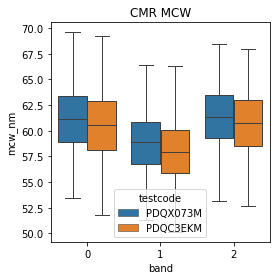

In [75]:
# PreRsvd MCW

%matplotlib inline

df = make_group(pd.read_pickle('dfMcw.pkl').query("row_num==1"))

#appel to apple check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'lhd', 'band', 'qualifier'], keep=False)]

fig, ax = plt.subplots(1,1, sharey=True, figsize=(4,4))
sns.boxplot(x="band", y="mcw_nm", hue='testcode', 
            data=df.query("row_num==1 and mcw > 0"),
            hue_order=hue_order,
            ax=ax, 
            linewidth=1)
ax.set_title('CMR MCW')
plt.tight_layout()
plt.savefig('mcw.png', format='png')

if rec_type != 'CMR':
    fig, ax = plt.subplots(1,1, sharey=True, figsize=(8,4))
    sns.boxplot(x="band", y="mcw_smr_nm", hue=hue, 
                data=df.query("qualifier=='2300' and row_num==1 and mcw_smr_nm > 0"),
                hue_order=hue_order,
                ax=ax, 
                linewidth=1)
    ax.set_title('SMR MCW')
    plt.tight_layout()
    plt.savefig('mcw_smr.png', format='png')


['CMR_G4', 'CMR_G4i']


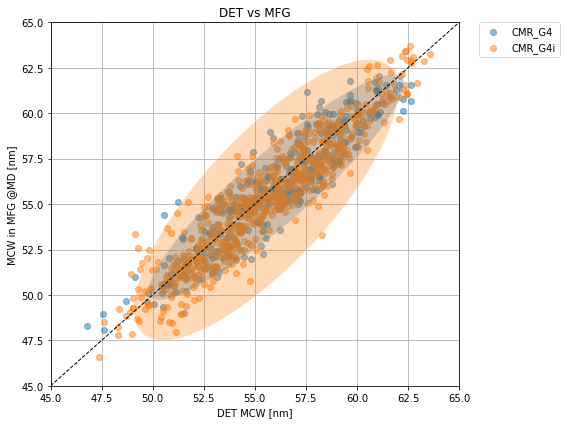

In [43]:
# MCW: DET vs MFG

df0 = make_group(pd.read_pickle('hddops_association.pkl').query("row_num==1"))
df1 = make_group(pd.read_pickle('dfMcw.pkl').query("row_num==1"))
df = df1.query("band==1").merge(df0, 
               left_on =['hddsn', 'mfgid', 'hddtrial', 'phd',     'Model', 'row_num'], 
               right_on=['hddsn', 'mfgid', 'hddtrial', 'pheadno', 'Model', 'row_num'],
               how='left'
              )

plot_xy(df, 
        'wew_r0_nm_sto_2', 'mcw_nm', 
        'DET MCW [nm]', 'MCW in MFG @MD [nm]', 'DET vs MFG', 
        'mcw_det_vs_mfg', disLegend=False, hue='Model', 
        xlim=[45,65], ylim=[45,65], 
        divX=None, divY=None, 
        addThresh=None, addYXLine=True, addRegLine=None, addEllipse=True)


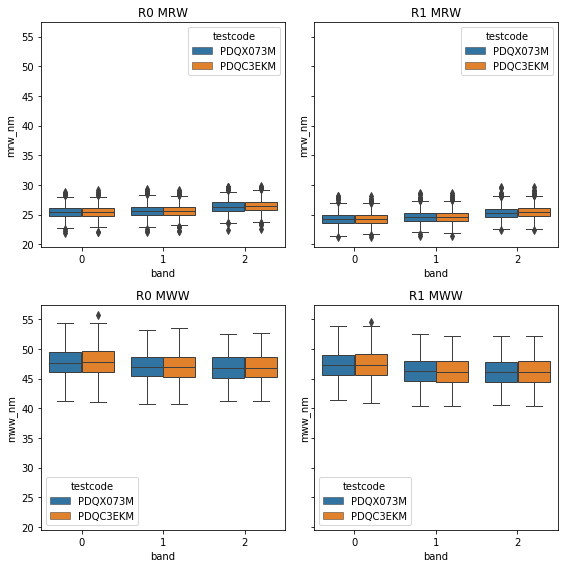

In [73]:
# PreRsvd MRW/MWW

%matplotlib inline
df = make_group(pd.read_pickle('dfMrw.pkl').query("row_num==1"))

#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'lhd', 'band', 'qualifier'], keep=False)]

fig, ax = plt.subplots(2,2, sharey=True, figsize=(8,8))
sns.boxplot(x="band", y="mrw_nm", hue=hue, 
            data=df.query("qualifier.str.endswith('00') and row_num==1 and mrw_nm > 0"), 
            hue_order=hue_order,
            ax=ax[0,0], 
            linewidth=1)
sns.boxplot(x="band", y="mrw_nm", hue=hue, 
            data=df.query("qualifier.str.endswith('10') and row_num==1 and mrw_nm > 0"), 
            hue_order=hue_order,
            ax=ax[0,1], 
            linewidth=1)
sns.boxplot(x="band", y="mww_nm", hue=hue, 
            data=df.query("qualifier.str.endswith('00') and row_num==1 and mww_nm > 0"),
            hue_order=hue_order,
            ax=ax[1,0], 
            linewidth=1)
sns.boxplot(x="band", y="mww_nm", hue=hue, 
            data=df.query("qualifier.str.endswith('10') and row_num==1 and mww_nm > 0"), 
            hue_order=hue_order,
            ax=ax[1,1], 
            linewidth=1)

ax[0,0].set_title('R0 MRW')
ax[0,1].set_title('R1 MRW')
ax[1,0].set_title('R0 MWW')
ax[1,1].set_title('R1 MWW')

plt.tight_layout()
plt.savefig('mrw_mww.png', format='png')


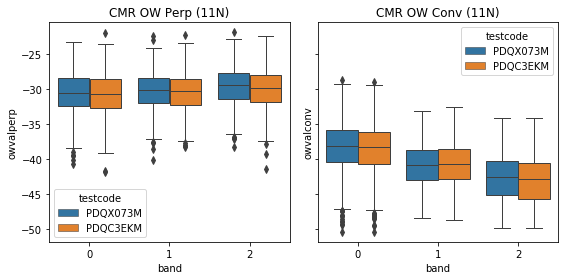

In [72]:
#over write (PreRsvd)

%matplotlib inline
df = make_group(pd.read_pickle('df_ccb_ci_ow.pkl').query("row_num==1"))

#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

#fig, ax = plt.subplots(2,2, sharey=True, figsize=(12,6))
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
sns.boxplot(x="band", y="owvalperp", hue=hue, data=df.query("qualifier=='11N0' and row_num==1"), ax=ax[0],
            #order=['31N0', '91H0', 'B0N0'],
            hue_order=hue_order,
            linewidth=1)
sns.boxplot(x="band", y="owvalconv", hue=hue, data=df.query("qualifier=='11N0' and row_num==1"), ax=ax[1],
            #order=['31N0', '91H0', 'B0N0'],
            hue_order=hue_order,
            linewidth=1)

ax[0].set_title('CMR OW Perp (11N)')
ax[1].set_title('CMR OW Conv (11N)')
plt.tight_layout()
plt.savefig('ow_11n.png', format='png')

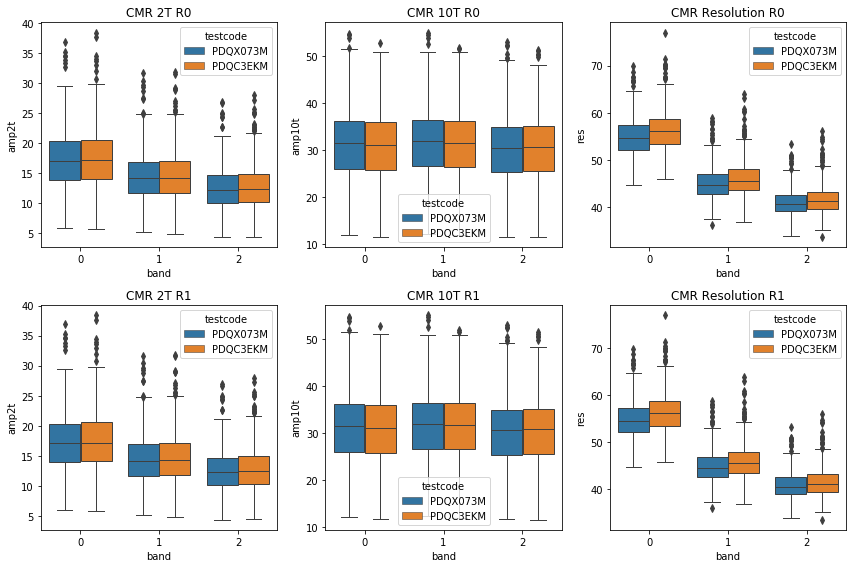

In [32]:
#amp

%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_amp.pkl').query("row_num==1")).query("mfgid.str.startswith('KQ')")

#duplication check
if a2a == True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

fig, ax = plt.subplots(2,3, sharey=False, figsize=(12,8))
sns.boxplot(x="band", y="amp2t", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1 and amp2t > 0"), 
            ax=ax[0,0],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="amp10t", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1 and amp10t > 0"), 
            ax=ax[0,1],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="res", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1 and amp10t > 0"), 
            ax=ax[0,2],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="amp2t", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1 and amp2t > 0"), 
            ax=ax[1,0],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="amp10t", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1 and amp10t > 0"), 
            ax=ax[1,1],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="res", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1 and amp10t > 0"), 
            ax=ax[1,2],
            hue_order=hue_order, 
            linewidth=1)


ax[0,0].set_title('CMR 2T R0')
ax[0,1].set_title('CMR 10T R0')
ax[0,2].set_title('CMR Resolution R0')
ax[1,0].set_title('CMR 2T R1')
ax[1,1].set_title('CMR 10T R1')
ax[1,2].set_title('CMR Resolution R1')

plt.tight_layout()
plt.savefig('amp_prersv.png', format='png')

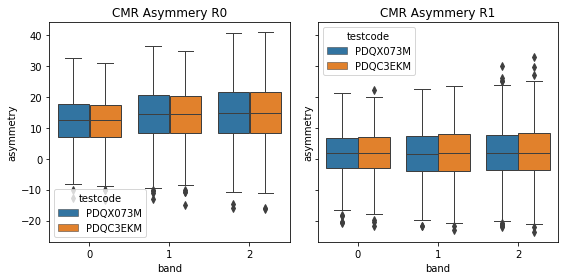

In [76]:
#asymmetry

hue = 'testcode'
hue_order = ['PDQX073M', 'PDQC3EKM']

%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_asm.pkl').query("row_num==1"))

if a2a == True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
sns.boxplot(x="band", y="asymmetry", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1"), 
            ax=ax[0],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="asymmetry", hue=hue, 
            data=df.query("qualifier=='1010' and row_num==1"), 
            ax=ax[1],
            hue_order=hue_order, 
            linewidth=1)

ax[0].set_title('CMR Asymmery R0')
ax[1].set_title('CMR Asymmery R1')

plt.tight_layout()
plt.savefig('asm_prersv.png', format='png')

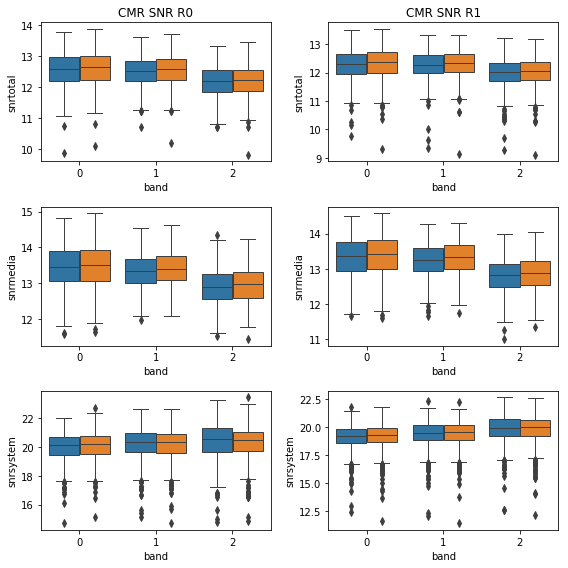

In [77]:
#snr
%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_rwip.pkl').query("row_num==1"))
df.loc[:,'snrtotal'] = df.loc[:,'snrtotal'].values.astype('float')
df.loc[:,'snrmedia'] = df.loc[:,'snrmedia'].values.astype('float')
df.loc[:,'snrsystem'] = df.loc[:,'snrsystem'].values.astype('float')

#duplication check
if a2a == True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

fig, ax = plt.subplots(3,2, sharey=False, figsize=(8,8))
sns.boxplot(x="band", y="snrtotal", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1 and snrtotal > 0"), 
            ax=ax[0,0],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="snrtotal", hue=hue, 
            data=df.query("qualifier=='1010' and row_num==1 and snrtotal > 0"), 
            ax=ax[0,1],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="snrmedia", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1 and snrtotal > 0"), 
            ax=ax[1,0],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="snrmedia", hue=hue, 
            data=df.query("qualifier=='1010' and row_num==1 and snrtotal > 0"), 
            ax=ax[1,1],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="snrsystem", hue=hue, 
            data=df.query("qualifier=='1000' and row_num==1 and snrtotal > 0"), 
            ax=ax[2,0],
            hue_order=hue_order, 
            linewidth=1)
sns.boxplot(x="band", y="snrsystem", hue=hue, 
            data=df.query("qualifier=='1010' and row_num==1 and snrtotal > 0"), 
            ax=ax[2,1],
            hue_order=hue_order, 
            linewidth=1)


ax[0,0].set_title('CMR SNR R0')
ax[0,1].set_title('CMR SNR R1')

for i in range(3):
    for j in range(2):
        ax[i,j].legend().remove()

plt.tight_layout()
plt.savefig('snr_prersv.png', format='png')

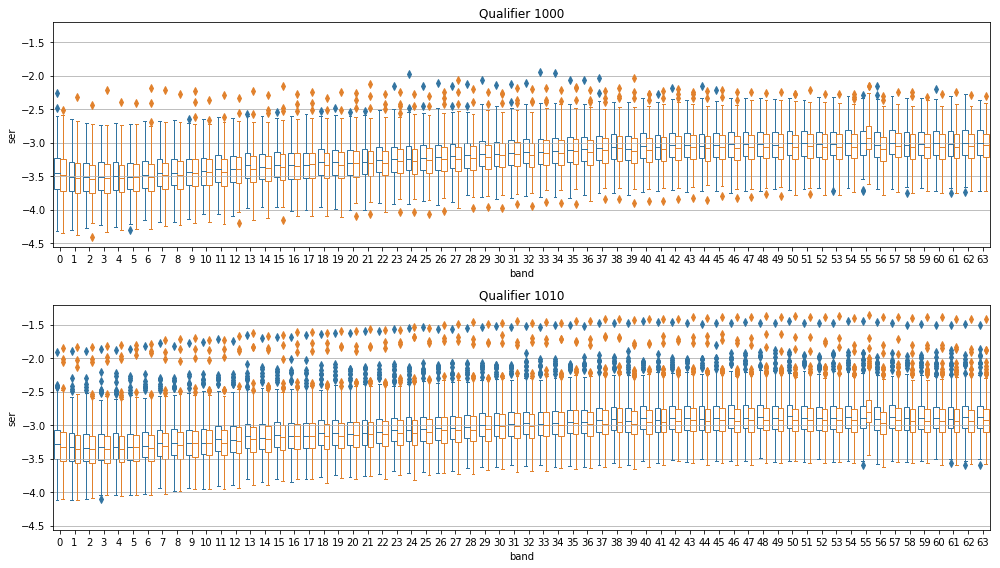

In [35]:
# SER in pre rsvd

%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_ser.pkl').query("row_num==1"))

#duplication check
if a2a == True:
    df = df[df.duplicated(subset=['hddsn', 'lhd', 'band', 'qualifier'], keep=False)]

#CMR
fig, ax = plt.subplots(2,1, sharey=True, figsize=(14,8))
for h, qual in enumerate(['1000', '1010']):
    sns.boxplot(x="band", y="ser", hue=hue, 
                data=df.query("qualifier=='%s' and row_num==1"%qual), 
                ax=ax[h],
                hue_order=hue_order,
                #order=[x for x in range(64)],
                #order=[0,10,20,31,41,52,63],
                linewidth=1)
    for i,artist in enumerate(ax[h].artists):
            # Set the linecolor on the artist to the facecolor, and set the facecolor to None
            col = artist.get_facecolor()
            artist.set_edgecolor(col)
            artist.set_facecolor('None')

            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*6,i*6+6):
                line = ax[h].lines[j]
                line.set_color(col)
                line.set_mfc(col)
                line.set_mec(col)
    ax[h].set_title('Qualifier %s'%qual)
    ax[h].legend().remove()
    ax[h].grid(axis='y', which='major')

plt.tight_layout()
plt.savefig('ser_prersv_cmr.png', format='png')


#SMR
if rec_type != 'CMR':
    fig, ax = plt.subplots(2,1, sharey=True, figsize=(14,8))
    for h, qual in enumerate(['2000', '2010']):
        sns.boxplot(x="band", y="ser", hue=hue, 
                    data=df.query("qualifier=='%s' and row_num==1"%qual), 
                    ax=ax[h],
                    hue_order=hue_order,
                    #order=[x for x in range(64)],
                    #order=[0,10,20,31,41,52,63],
                    linewidth=1)
        for i,artist in enumerate(ax[h].artists):
                # Set the linecolor on the artist to the facecolor, and set the facecolor to None
                col = artist.get_facecolor()
                artist.set_edgecolor(col)
                artist.set_facecolor('None')

                # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                # Loop over them here, and use the same colour as above
                for j in range(i*6,i*6+6):
                    line = ax[h].lines[j]
                    line.set_color(col)
                    line.set_mfc(col)
                    line.set_mec(col)
        ax[h].set_title('Qualifier %s'%qual)
        ax[h].legend().remove()
        ax[h].grid(axis='y', which='major')

    plt.tight_layout()
    plt.savefig('ser_prersv_smr.png', format='png')

# Format Parameters

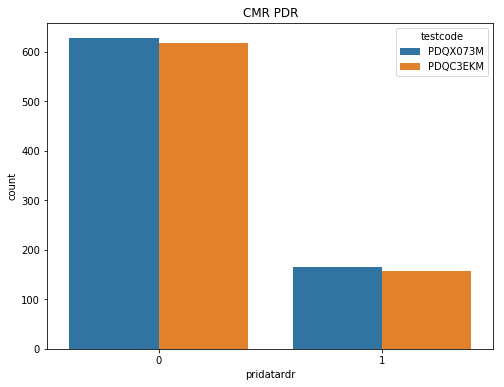

In [36]:
#primary data reader check

%matplotlib inline

df = pd.read_pickle('df_ccb_ci_crsbn_datareader.pkl')
df = make_group(df)

if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd'], keep=False)]

#CMR
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax = sns.countplot(x="pridatardr", hue=hue, 
                   hue_order=hue_order,
                   data=df.query("qualifier=='1000' and readerindex==0 and row_num==1"),
                   order=[0,1]
                  )
ax.set_title('CMR PDR')
plt.savefig('pdr_cmr.png', format='png')

#SMR
if rec_type != 'CMR':
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax = sns.countplot(x="pridatardr", hue=hue, 
                       hue_order=hue_order,
                       data=df.query("qualifier=='2010' and readerindex==0 and row_num==1"),
                       order=[0,1]
                  )
    ax.set_title('SMR PDR')
    plt.savefig('pdr_smr.png', format='png')

Using matplotlib backend: Qt5Agg


'\nfigname = \'rsbn_smr_pdqx071m\'\nfig, ax = plt.subplots(1,1, figsize=(8,6))\na = df.query("testcode==\'PDQX071M\'").loc[:,[\'datardrs_2010_\'+str(x) for x in range(64)]].values\nnum = a.shape[0]\nax.bar(np.arange(64), np.count_nonzero(a==1, axis=0)/num, color=\'C0\', label=\'R0\')\nax.bar(np.arange(64), np.count_nonzero(a==2, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num, color=\'C1\', label=\'R1\')\nax.bar(np.arange(64), np.count_nonzero(a==3, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num+np.count_nonzero(a==2, axis=0)/num, color=\'C2\', label=\'R0R1\')\n#ax.legend(loc=\'best\')\nax.legend(bbox_to_anchor=(1.01, 1), loc=\'upper left\', borderaxespad=0, fontsize=10)\nax.set_xlabel(\'Band#\')\nax.set_title(\'RSBN (SMR, PDQX071M)\')\nplt.tight_layout()\nplt.savefig(figname+\'.png\', format=\'png\')\n'

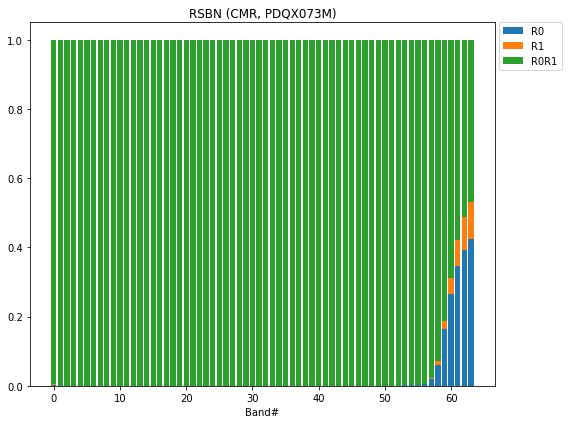

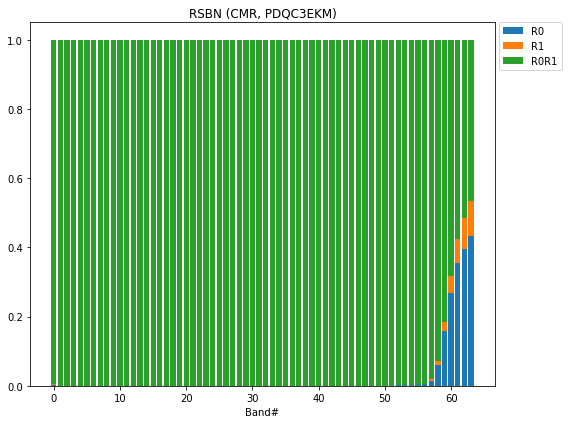

In [50]:
#RSBN (Full Capacity, SMR)
%matplotlib inline


df = pd.read_pickle('dfRsbnFlat.pkl')
df = make_group(df)
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'lhd'], keep=False)]

#CMR
figname = 'rsbn_cmr_pdqx073m'
fig, ax = plt.subplots(1,1, figsize=(8,6))
pd.read_pickle('dfRsbnFlat.pkl')
a = df.query("testcode=='PDQX073M'").loc[:,['datardrs_1000_'+str(x) for x in range(64)]].values
num = a.shape[0]
ax.bar(np.arange(64), np.count_nonzero(a==1, axis=0)/num, color='C0', label='R0')
ax.bar(np.arange(64), np.count_nonzero(a==2, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num, color='C1', label='R1')
ax.bar(np.arange(64), np.count_nonzero(a==3, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num+np.count_nonzero(a==2, axis=0)/num, color='C2', label='R0R1')
#ax.legend(loc='best')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
ax.set_xlabel('Band#')
ax.set_title('RSBN (CMR, PDQX073M)')
plt.tight_layout()
plt.savefig(figname+'.png', format='png')


figname = 'rsbn_cmr_pdqc3ekm'
fig, ax = plt.subplots(1,1, figsize=(8,6))
a = df.query("testcode=='PDQC3EKM'").loc[:,['datardrs_1000_'+str(x) for x in range(64)]].values
num = a.shape[0]
ax.bar(np.arange(64), np.count_nonzero(a==1, axis=0)/num, color='C0', label='R0')
ax.bar(np.arange(64), np.count_nonzero(a==2, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num, color='C1', label='R1')
ax.bar(np.arange(64), np.count_nonzero(a==3, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num+np.count_nonzero(a==2, axis=0)/num, color='C2', label='R0R1')
#ax.legend(loc='best')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
ax.set_xlabel('Band#')
ax.set_title('RSBN (CMR, PDQC3EKM)')
plt.tight_layout()
plt.savefig(figname+'.png', format='png')


"""
#SMR
figname = 'rsbn_smr_pdqx083m'
fig, ax = plt.subplots(1,1, figsize=(8,6))
a = df.query("testcode=='PDQX083M'").loc[:,['datardrs_2010_'+str(x) for x in range(64)]].values
num = a.shape[0]
ax.bar(np.arange(64), np.count_nonzero(a==1, axis=0)/num, color='C0', label='R0')
ax.bar(np.arange(64), np.count_nonzero(a==2, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num, color='C1', label='R1')
ax.bar(np.arange(64), np.count_nonzero(a==3, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num+np.count_nonzero(a==2, axis=0)/num, color='C2', label='R0R1')
#ax.legend(loc='best')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
ax.set_xlabel('Band#')
ax.set_title('RSBN (SMR, PDQX083M)')
plt.tight_layout()
plt.savefig(figname+'.png', format='png')
"""

"""
figname = 'rsbn_smr_pdqx071m'
fig, ax = plt.subplots(1,1, figsize=(8,6))
a = df.query("testcode=='PDQX071M'").loc[:,['datardrs_2010_'+str(x) for x in range(64)]].values
num = a.shape[0]
ax.bar(np.arange(64), np.count_nonzero(a==1, axis=0)/num, color='C0', label='R0')
ax.bar(np.arange(64), np.count_nonzero(a==2, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num, color='C1', label='R1')
ax.bar(np.arange(64), np.count_nonzero(a==3, axis=0)/num, bottom=np.count_nonzero(a==1, axis=0)/num+np.count_nonzero(a==2, axis=0)/num, color='C2', label='R0R1')
#ax.legend(loc='best')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
ax.set_xlabel('Band#')
ax.set_title('RSBN (SMR, PDQX071M)')
plt.tight_layout()
plt.savefig(figname+'.png', format='png')
"""

['PDQX073M', 'PDQC3EKM']
float64
float64


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\matplotlib\axes\_axes.py:6612: RuntimeWarning: invalid value encountered in multiply
  tops = [(m * np.diff(bins))[slc].cumsum()[slc] for m in tops]


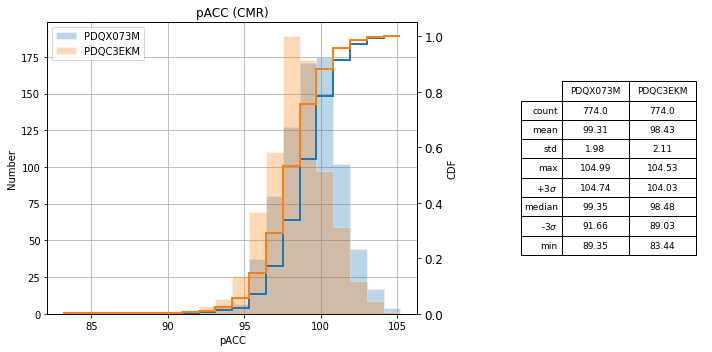

In [13]:
#ACC
%matplotlib inline    

df = make_group(pd.read_pickle('dfUfoHdArry.pkl').query("row_num==1"))
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd'], keep=False)]

#CMR
plot_cdf(df.query("accheadtotallbaformat>0 and qualifier=='1000'"), 
         'pacc_pct', 
         'pACC', 'pACC (CMR)',
         'pacc_pct_cmr', xlim=None, hue=hue, hue_order=hue_order, div=None, addThresh=None, binSize=20, addTable=True)

#SMR
if rec_type != 'CMR':
    plot_cdf(df.query("accheadtotallbaformat>0 and qualifier=='2000'"), 
             'iacc_pct', 
             'ACC', 'ACC (SMR)', 
             'iacc_pct_smr', xlim=None, hue=hue, hue_order=hue_order, div=None, addThresh=None, binSize=20, addTable=True)

['PDQX073M', 'PDQC3EKM', 'PCMGH40C']
float64
float64
float64


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\matplotlib\axes\_axes.py:6612: RuntimeWarning: invalid value encountered in multiply
  tops = [(m * np.diff(bins))[slc].cumsum()[slc] for m in tops]


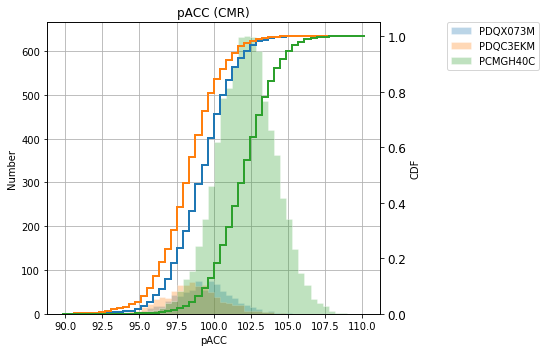

In [40]:
#ACC: PCM vs PDQ

%matplotlib inline    
hue_order2 = ['PDQX073M', 'PDQC3EKM', 'PCMGH40C']
df = make_group(pd.read_pickle('dfUfoHdArry.pkl').query("row_num==1"))
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd'], keep=False)]

#append pcm data
df = df.append(pd.read_pickle('pcm/dfUfoHdArry.pkl').query("row_num==1"))
    
#CMR
plot_cdf(df.query("accheadtotallbaformat>0 and qualifier.str.startswith('100')"), 
         'pacc_pct', 
         'pACC', 'pACC (CMR)',
         'pacc_pct_pcm_vs_pdq_cmr', xlim=[90,110], hue=hue, hue_order=hue_order2, div=None, addThresh=None, binSize=50, addTable=False)

In [ ]:
# DET MCW vs ACC

df0 = make_group(pd.read_pickle('hddops_association.pkl').query("row_num==1"))
df1 = make_group(pd.read_pickle('dfMcw.pkl').query("row_num==1")).query("mfgid.str.startswith('KQ')")
df = df1.query("band==1").merge(df0, 
               left_on =['hddsn', 'mfgid', 'hddtrial', 'phd',     'Model', 'row_num'], 
               right_on=['hddsn', 'mfgid', 'hddtrial', 'pheadno', 'Model', 'row_num'],
               how='left'
              )

plot_xy(df, 
        'wew_r0_nm_sto_2', 'mcw_nm', 
        'DET MCW [nm]', 'MCW in MFG @MD [nm]', 'DET vs MFG', 
        'mcw_det_vs_mfg', disLegend=False, hue='Model', 
        xlim=[45,65], ylim=[45,65], 
        divX=None, divY=None, 
        addThresh=None, addYXLine=True, addRegLine=None, addEllipse=True)


['PDQX073M', 'PDQC3EKM']
int64
int64


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\matplotlib\axes\_axes.py:6612: RuntimeWarning: invalid value encountered in multiply
  tops = [(m * np.diff(bins))[slc].cumsum()[slc] for m in tops]


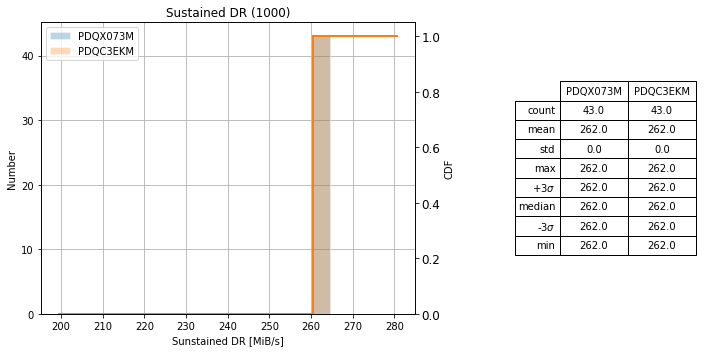

In [42]:
#Sustained DR

%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_ufo.pkl').query("row_num==1"))
#check duplication
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier'], keep=False)]

#CMR
plot_cdf(df.query("finalsustainedmbytepersec>0 and qualifier=='1000'"), 
         'finalsustainedmbytepersec', 
         'Sunstained DR [MiB/s]', 'Sustained DR (1000)', 
         'sustainedDrCmr', xlim=[200, 280], hue=hue, hue_order=hue_order, div=None, addThresh=None, binSize=20, addTable=True)

#SMR
if rec_type != 'CMR':
    plot_cdf(df.query("finalsustainedmbytepersec>0 and qualifier=='2000'"), 
             'finalsustainedmbytepersec', 
             'Sunstained DR [MiB/s]', 'Sustained DR (2000)', 
             'sustainedDrSmr', xlim=None, hue=hue, hue_order=hue_order, div=None, addThresh=None, binSize=5, addTable=True)

['PDQX073M', 'PDQC3EKM', 'PCMGH40C']
int64
int64
int64


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\matplotlib\axes\_axes.py:6612: RuntimeWarning: invalid value encountered in multiply
  tops = [(m * np.diff(bins))[slc].cumsum()[slc] for m in tops]


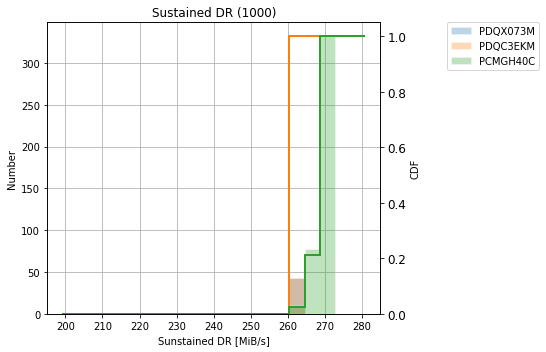

In [43]:
#Sustained DR: PCM vs PDQ

%matplotlib inline
hue_order2 = ['PDQX073M', 'PDQC3EKM', 'PCMGH40C']
df = make_group(pd.read_pickle('df_ccb_ci_ufo.pkl').query("row_num==1"))
#check duplication
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier'], keep=False)]

#append PCM
df= df.append(pd.read_pickle('pcm/df_ccb_ci_ufo.pkl').query("row_num==1"))
    
#CMR
plot_cdf(df.query("finalsustainedmbytepersec>0 and qualifier.str.startswith('100')"), 
         'finalsustainedmbytepersec', 
         'Sunstained DR [MiB/s]', 'Sustained DR (1000)', 
         'sustainedDrCmr_pcm_vs_pdq', xlim=[200, 280], hue=hue, hue_order=hue_order2, div=None, addThresh=None, binSize=20, addTable=False)

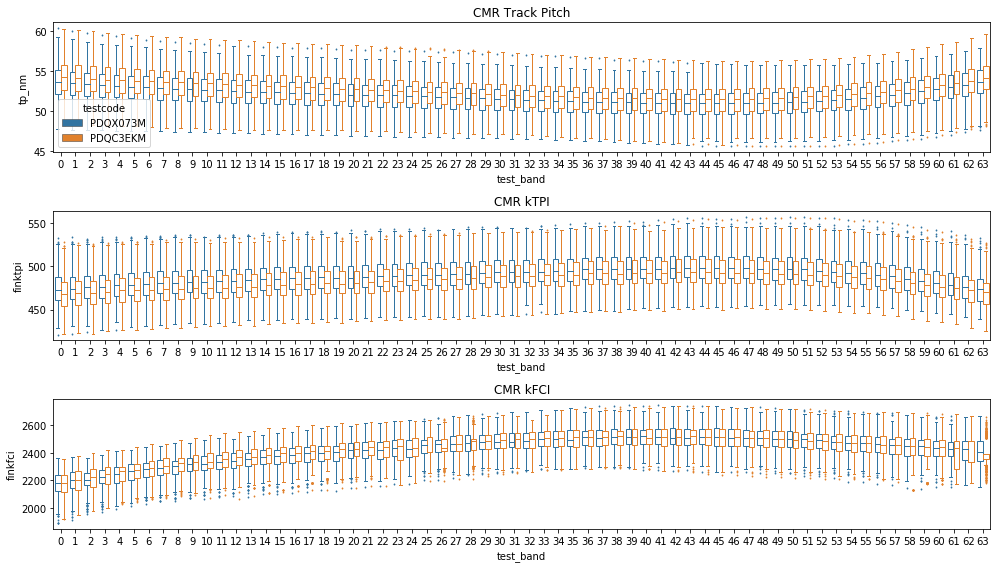

In [44]:
#TP, kFCI, kTPI

%matplotlib inline

df = make_group(pd.read_pickle('dfUfoSubCmd7.pkl').query("row_num==1")).query("mfgid.str.startswith('KQ')")
#check duplication
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'test_band'], keep=False)]

#CMR
fig, ax = plt.subplots(3,1, sharey=False, figsize=(14,8))
sns.boxplot(x="test_band", y="tp_nm", hue=hue, 
            data=df.query("qualifier=='3000' and row_num==1"), 
            ax=ax[0],
            hue_order=hue_order,
            fliersize=1,
            #order=[x for x in range(64)],
            #order=[0,10,20,31,41,52,63],
            linewidth=1)
for i,artist in enumerate(ax[0].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax[0].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
ax[0].set_title('CMR Track Pitch')

sns.boxplot(x="test_band", y="finktpi", hue=hue, 
            data=df.query("qualifier=='3000' and row_num==1"), 
            ax=ax[1],
            hue_order=hue_order,
            fliersize=1,
            #order=[x for x in range(64)],
            #order=[0,10,20,31,41,52,63],
            linewidth=1)
for i,artist in enumerate(ax[1].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax[1].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
ax[1].set_title('CMR kTPI')

sns.boxplot(x="test_band", y="finkfci", hue=hue, 
            data=df.query("qualifier=='3000' and row_num==1"), 
            ax=ax[2],
            hue_order=hue_order,
            fliersize=1,
            #order=[x for x in range(64)],
            #order=[0,10,20,31,41,52,63],
            linewidth=1)
for i,artist in enumerate(ax[2].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax[2].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
ax[2].set_title('CMR kFCI')
ax[1].legend(loc='upper left').remove()
ax[2].legend(loc='upper left').remove()

plt.tight_layout()
plt.savefig('final_format_cmr.png', format='png')


#SMR
if rec_type != 'CMR':
#TP
    fig, ax = plt.subplots(3,1, sharey=False, figsize=(14,8))
    sns.boxplot(x="test_band", y="tp_nm", hue=hue, 
                data=df.query("qualifier=='4000' and row_num==1"), 
                ax=ax[0],
                hue_order=hue_order,
                fliersize=1,
                #order=[x for x in range(64)],
                #order=[0,10,20,31,41,52,63],
                linewidth=1)
    for i,artist in enumerate(ax[0].artists):
            # Set the linecolor on the artist to the facecolor, and set the facecolor to None
            col = artist.get_facecolor()
            artist.set_edgecolor(col)
            artist.set_facecolor('None')

            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*6,i*6+6):
                line = ax[0].lines[j]
                line.set_color(col)
                line.set_mfc(col)
                line.set_mec(col)
    ax[0].set_title('SMR Track Pitch')

    sns.boxplot(x="test_band", y="finktpi", hue=hue, 
                data=df.query("qualifier=='4000' and row_num==1"), 
                ax=ax[1],
                hue_order=hue_order,
                fliersize=1,
                #order=[x for x in range(64)],
                #order=[0,10,20,31,41,52,63],
                linewidth=1)
    for i,artist in enumerate(ax[1].artists):
            # Set the linecolor on the artist to the facecolor, and set the facecolor to None
            col = artist.get_facecolor()
            artist.set_edgecolor(col)
            artist.set_facecolor('None')

            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*6,i*6+6):
                line = ax[1].lines[j]
                line.set_color(col)
                line.set_mfc(col)
                line.set_mec(col)
    ax[1].set_title('SMR kTPI')

    sns.boxplot(x="test_band", y="finkfci", hue=hue, 
                data=df.query("qualifier=='4000' and row_num==1"), 
                ax=ax[2],
                hue_order=hue_order,
                fliersize=1,
                #order=[x for x in range(64)],
                #order=[0,10,20,31,41,52,63],
                linewidth=1)
    for i,artist in enumerate(ax[2].artists):
            # Set the linecolor on the artist to the facecolor, and set the facecolor to None
            col = artist.get_facecolor()
            artist.set_edgecolor(col)
            artist.set_facecolor('None')

            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*6,i*6+6):
                line = ax[2].lines[j]
                line.set_color(col)
                line.set_mfc(col)
                line.set_mec(col)
    ax[2].set_title('SMR kFCI')
    ax[1].legend(loc='upper left').remove()
    ax[2].legend(loc='upper left').remove()

    plt.tight_layout()
    plt.savefig('final_format_smr.png', format='png')

['All']
int64


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\matplotlib\axes\_axes.py:6612: RuntimeWarning: invalid value encountered in multiply
  tops = [(m * np.diff(bins))[slc].cumsum()[slc] for m in tops]


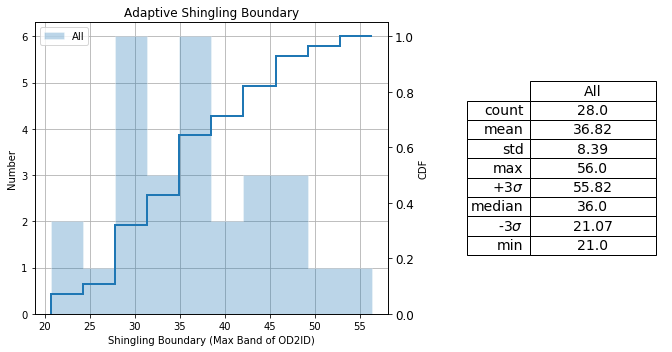

In [15]:
#ASB

%matplotlib inline
df = make_group(pd.read_pickle('df_ccb_ci_casb.pkl').query("row_num==1"))

#df.loc[df['testcode']=='PDQZ066M', 'testcode']='0_PDQZ066M'
#df.loc[df['testcode']=='PDQX071M', 'testcode']='1_PDQX071M'

plot_cdf(df.query("row_num==1"), 
         'maxbandod2id', 
         'Shingling Boundary (Max Band of OD2ID)', 'Adaptive Shingling Boundary', 
         'asb_2300', 
         xlim=None, hue=None, div=None, addThresh=None, binSize=10, addTable=True)

# Parametric in Adaptive Format

C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\seaborn\categorical.py:410: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
No handles with labels found to put in legend.
C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\seaborn\categorical.py:410: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


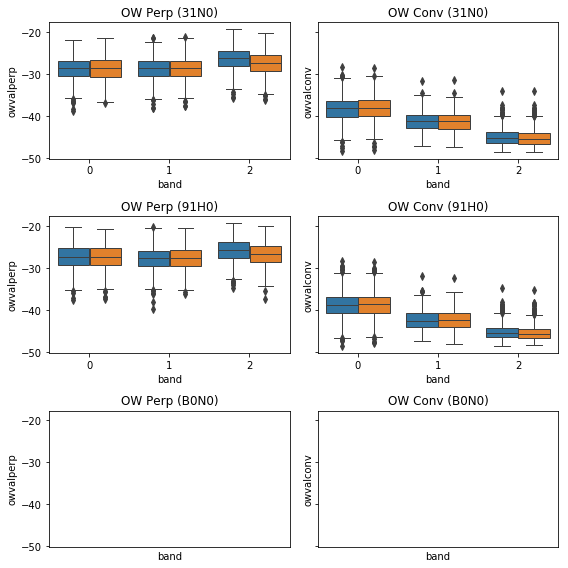

In [78]:
#over write
%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_ow.pkl').query("row_num==1"))
#check duplication
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

#CMR
fig, ax = plt.subplots(3,2, sharey=True, figsize=(8,8))
for i, qual in enumerate(['31N0', '91H0', 'B0N0']):
    sns.boxplot(x="band", y="owvalperp", hue=hue, data=df.query("qualifier=='%s' and row_num==1"%qual), ax=ax[i,0],
            hue_order=hue_order,
            linewidth=1)
    sns.boxplot(x="band", y="owvalconv", hue=hue, data=df.query("qualifier=='%s' and row_num==1"%qual), ax=ax[i,1],
            hue_order=hue_order,
            linewidth=1)
    ax[i,0].set_title('OW Perp (%s)'%qual)
    ax[i,1].set_title('OW Conv (%s)'%qual)
    ax[i,0].legend().remove()
    ax[i,1].legend().remove()

plt.tight_layout()
plt.savefig('ow_cmr.png', format='png')


#SMR
if rec_type != 'CMR':
    fig, ax = plt.subplots(3,2, sharey=True, figsize=(8,8))
    for i, qual in enumerate(['41N0', 'K1H0', 'M0N0']):
        sns.boxplot(x="band", y="owvalperp", hue=hue, data=df.query("qualifier=='%s' and row_num==1"%qual), ax=ax[i,0],
                hue_order=hue_order,
                linewidth=1)
        sns.boxplot(x="band", y="owvalconv", hue=hue, data=df.query("qualifier=='%s' and row_num==1"%qual), ax=ax[i,1],
                hue_order=hue_order,
                linewidth=1)
        ax[i,0].set_title('OW Perp (%s)'%qual)
        ax[i,1].set_title('OW Conv (%s)'%qual)
        ax[i,0].legend().remove()
        ax[i,1].legend().remove()
    
    plt.tight_layout()
    plt.savefig('ow_smr.png', format='png')
    

C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\seaborn\categorical.py:410: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


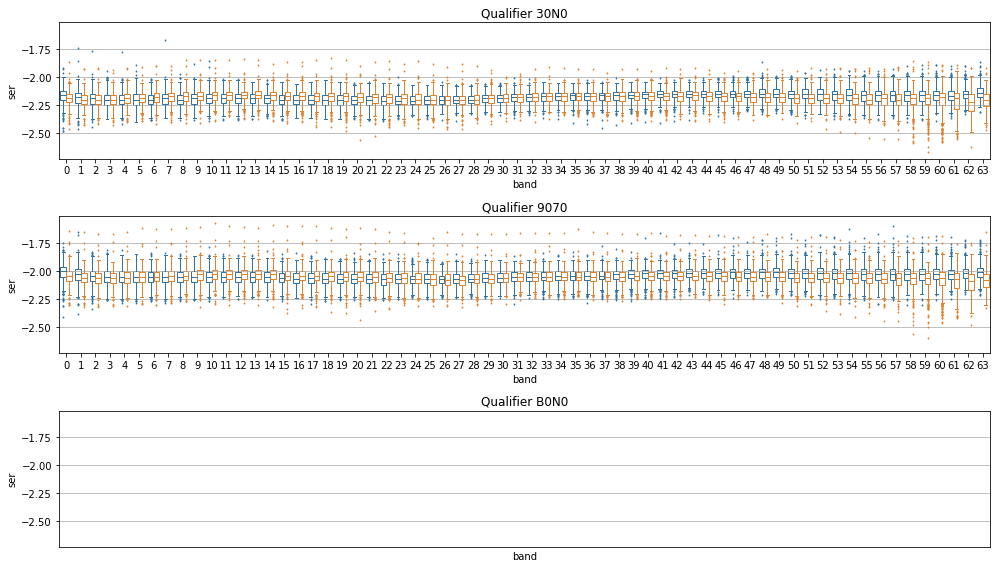

In [46]:
# SER
%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_ser.pkl').query("row_num==1"))
#check duplication
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

#CMR
fig, ax = plt.subplots(3,1, sharey=True, figsize=(14,8))
for h, qual in enumerate(['30N0', '9070', 'B0N0']):
    sns.boxplot(x="band", y="ser", hue=hue, 
                data=df.query("qualifier=='%s' and row_num==1"%qual), 
                ax=ax[h],
                hue_order=hue_order,
                fliersize=1,
                #order=[x for x in range(64)],
                #order=[0,10,20,31,41,52,63],
                linewidth=1)
    for i,artist in enumerate(ax[h].artists):
            # Set the linecolor on the artist to the facecolor, and set the facecolor to None
            col = artist.get_facecolor()
            artist.set_edgecolor(col)
            artist.set_facecolor('None')

            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for j in range(i*6,i*6+6):
                line = ax[h].lines[j]
                line.set_color(col)
                line.set_mfc(col)
                line.set_mec(col)
    ax[h].set_title('Qualifier %s'%qual)
    ax[h].legend().remove()
    ax[h].grid(axis='y', which='major')

plt.tight_layout()
plt.savefig('ser_cmr.png', format='png')


#SMR
if rec_type != 'CMR':
    fig, ax = plt.subplots(3,1, sharey=True, figsize=(14,8))
    for h, qual in enumerate(['40N0', 'K070', 'M0N0']):
        sns.boxplot(x="band", y="ser", hue=hue, 
                    data=df.query("qualifier=='%s' and row_num==1"%qual), 
                    ax=ax[h],
                    hue_order=hue_order,
                    fliersize=1,
                    #order=[x for x in range(64)],
                    #order=[0,10,20,31,41,52,63],
                    linewidth=1)
        for i,artist in enumerate(ax[h].artists):
                # Set the linecolor on the artist to the facecolor, and set the facecolor to None
                col = artist.get_facecolor()
                artist.set_edgecolor(col)
                artist.set_facecolor('None')

                # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
                # Loop over them here, and use the same colour as above
                for j in range(i*6,i*6+6):
                    line = ax[h].lines[j]
                    line.set_color(col)
                    line.set_mfc(col)
                    line.set_mec(col)
        ax[h].set_title('Qualifier %s'%qual)
        ax[h].legend().remove()
        ax[h].grid(axis='y', which='major')

    plt.tight_layout()
    plt.savefig('ser_smr.png', format='png')
    

C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


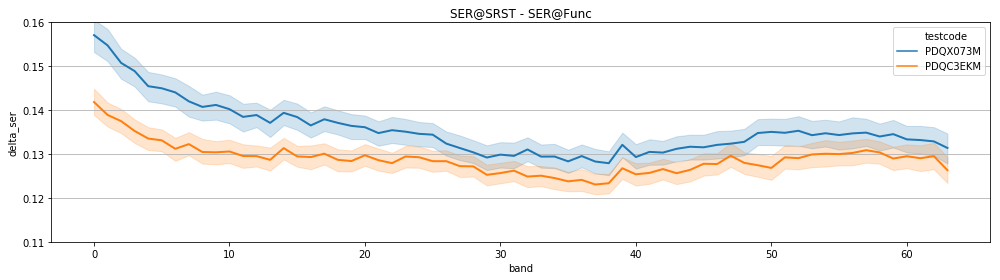

In [79]:
# Average Delta SER in CMR

%matplotlib inline
df = make_group(pd.read_pickle('df_ccb_ci_ser.pkl').query("row_num==1 and qualifier in ['30N0', '9070']"))
#check duplication
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

dfflat = df.query("qualifier=='30N0'").merge(df.query("qualifier=='9070'"),
                                                                left_on  = ['hddsn', 'testcode', 'mfgid', 'hddtrial', 'lhd', 'phd', 'band'],
                                                                right_on = ['hddsn', 'testcode', 'mfgid', 'hddtrial', 'lhd', 'phd', 'band'],
                                                                how='inner',
                                                                suffixes=['_func', '_srst'])
dfflat.loc[:,'delta_ser'] = dfflat.loc[:,'ser_srst'].values - dfflat.loc[:,'ser_func'].values

#CMR
fig, ax = plt.subplots(1,1, sharey=True, sharex=False, figsize=(14,4))
sns.lineplot(x="band", y="delta_ser", hue=hue, 
             data=dfflat, 
             ax=ax,
             #ci=None,
             hue_order=hue_order,
             #legend='brief',
             #order=[x for x in range(64)],
             #order=[0,10,20,31,41,52,63],
             linewidth=2)
ax.set_title('SER@SRST - SER@Func')
ax.set_ylim((0.11,0.16))
ax.grid(axis='y', which='both')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('delta_ser_average_cmr.png', format='png')

# AIw

C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


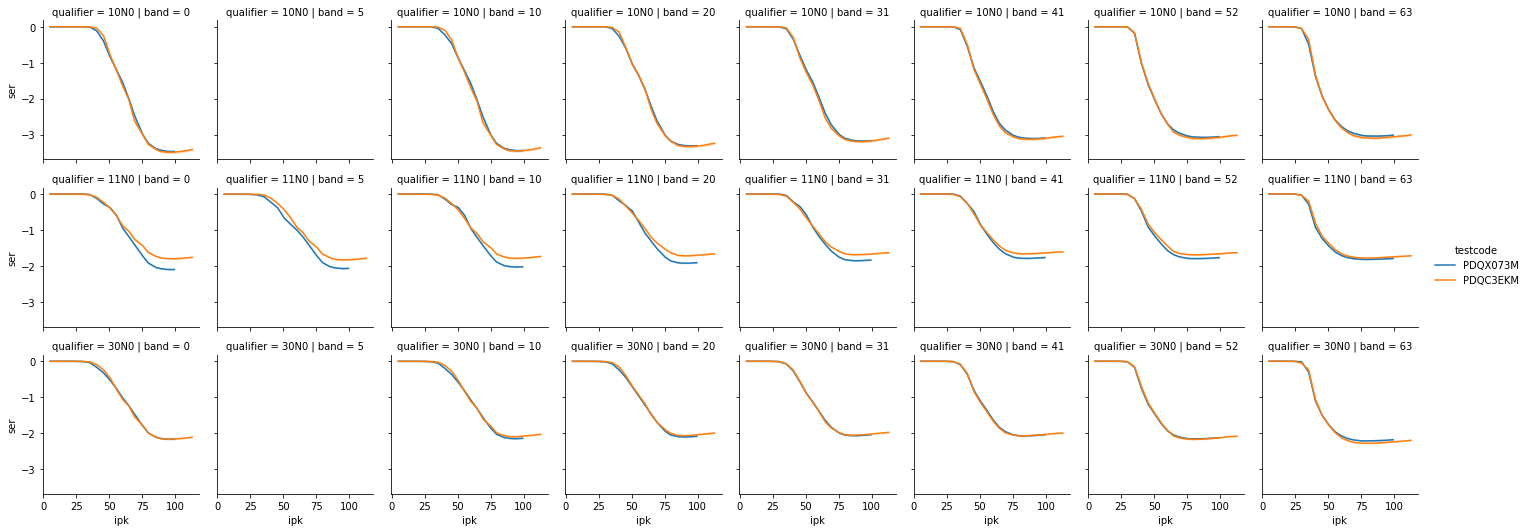

In [48]:
#AIw profile

%matplotlib inline

#CMR
df = make_group(pd.read_pickle('dfAIwProfile.pkl').query("row_num==1"))
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

#df.loc[:,'hddsnlhd'] = df.loc[:,'hddsn'] + df.loc[:,'lhd'].astype('str') + df.loc[:,]
grid = sns.FacetGrid(df, 
                     col='band',
                     row="qualifier",
                     row_order = ['10N0', '11N0', '30N0'],
                     hue=hue, 
                     legend_out=True,
                     hue_order=hue_order,
                     #palette="tab20c",
                     #palette="coolwarm",
                     #col_wrap=7, 
                     height=2.5)
grid.map(sns.lineplot, 'ipk', 'ser')
grid.add_legend()
plt.savefig('aiwprofile.png', format = 'png')


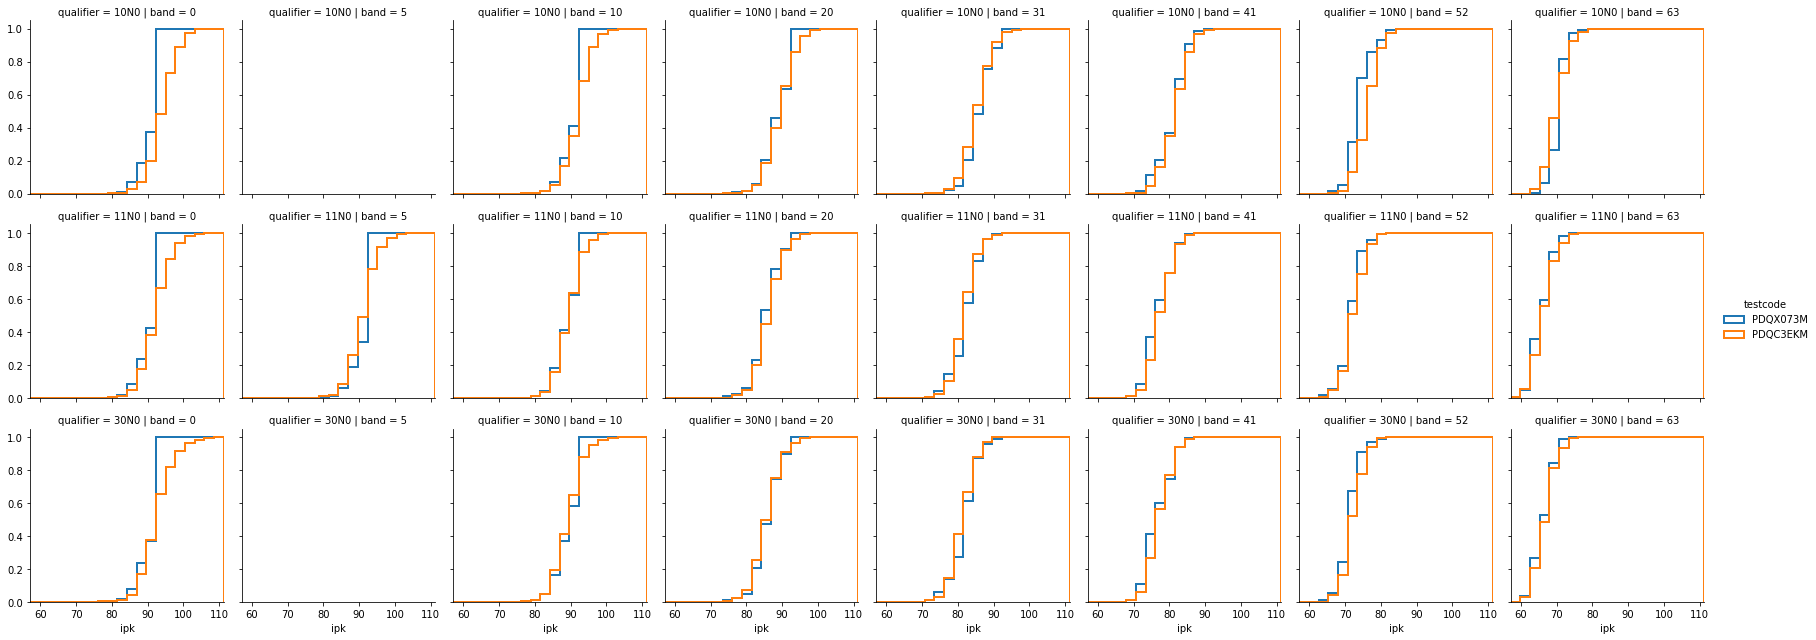

In [50]:
#AIw histgram

%matplotlib inline

#CMR
df = make_group(pd.read_pickle('dfAIw.pkl').query("row_num==1"))
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

binSize = 20
xmax = np.max(df.loc[:,'ipk'].values)
xmin = np.min(df.loc[:,'ipk'].values)
xrng = xmax - xmin
xmax += xrng*0.01
xmin -= xrng*0.01
xrng = xmax - xmin
binArray = list(np.linspace(xmin, xmax, binSize+1))
bins=binArray+[np.inf]

grid = sns.FacetGrid(df, 
                     col='band',
                     row="qualifier",
                     row_order = ['10N0', '11N0', '30N0'],
                     hue=hue, 
                     legend_out=True,
                     hue_order=hue_order,
                     #palette="tab20c",
                     #palette="coolwarm",
                     #col_wrap=7, 
                     height=3)
grid.map(plt.hist, 'ipk', cumulative=True, density=True, histtype='step', bins=binArray, linewidth=2)
grid.add_legend()
grid.set(#xticks=np.arange(5), yticks=[-3, 3],
         xlim=(xmin, xmax))
    # Draw a line plot to show the trajectory of each random walk
    #grid.map(plt.plot, "band", 'WriteCurrent')
    #grid.set(#xticks=np.arange(5), yticks=[-3, 3],
    #         ylim=(1e-1, 1000))
plt.savefig('aiw_cmr.png', format = 'png')


#SMR
if rec_type != 'CMR':
    df = make_group(pd.read_pickle('dfAIw.pkl').query("row_num==1"))
    binSize = 20
    xmax = np.max(df.loc[:,'ipk'].values)
    xmin = np.min(df.loc[:,'ipk'].values)
    xrng = xmax - xmin
    xmax += xrng*0.01
    xmin -= xrng*0.01
    xrng = xmax - xmin
    binArray = list(np.linspace(xmin, xmax, binSize+1))
    bins=binArray+[np.inf]

    grid = sns.FacetGrid(df, 
                         col='band',
                         row="qualifier",
                         row_order = ['20N0', '40N0'],
                         hue=hue, 
                         legend_out=True,
                         hue_order=hue_order,
                         #palette="tab20c",
                         #palette="coolwarm",
                         #col_wrap=7, 
                         height=3)
    grid.map(plt.hist, 'ipk', cumulative=True, density=True, histtype='step', bins=binArray, linewidth=2)
    grid.add_legend()
    grid.set(#xticks=np.arange(5), yticks=[-3, 3],
             xlim=(xmin, xmax))
    # Draw a line plot to show the trajectory of each random walk
    #grid.map(plt.plot, "band", 'WriteCurrent')
    #grid.set(#xticks=np.arange(5), yticks=[-3, 3],
    #         ylim=(1e-1, 1000))
    plt.savefig('aiw_smr.png', format = 'png')
    

In [12]:
df0 = make_group(pd.read_pickle('hddops_association.pkl').query("row_num==1"))
df1 = make_group(pd.read_pickle('dfMcw.pkl').query("row_num==1"))
df = df1.query("band==1").merge(df0, 
               left_on =['hddsn', 'mfgid', 'hddtrial', 'phd',     'Model', 'row_num'], 
               right_on=['hddsn', 'mfgid', 'hddtrial', 'pheadno', 'Model', 'row_num'],
               how='left'
              )
df

,hddsn,pfcode,testcode,mfgid,hddtrial,qualifier,band,phd,lhd,mcw,...,mcw_nm,mcw_smr_nm,Model,product,slidersn,pheadno,procid,enddate,storeday,wew_r0_nm_sto_2
0,2FA052AA,0000,PDQC36VM,KKB304,M1HW,10N0,1,3,3,106.860352,...,54.285059,0.0,CMR_G4i,pdq,4B8F132714,3,6400,20201005182549,2020-08-06,54.2225
1,2FA0531A,0000,PDQC36VM,KKB304,M1HW,10N0,1,4,4,115.112305,...,58.477051,0.0,CMR_G4i,pdq,4B8F12C22D,4,6400,20201005190631,2020-08-05,57.6123
2,2FA053ZA,0000,PDQC36VM,KKB301,M1HX,10N0,1,3,3,109.545898,...,55.649316,0.0,CMR_G4,pdq,4B8F114715,3,6400,20201005185238,2020-08-05,57.1156
3,2FA0532A,0000,PDQC36VM,KKB304,M1HW,10N0,1,3,3,116.333008,...,59.097168,0.0,CMR_G4i,pdq,4B8F11450F,3,6400,20201005183935,2020-08-05,56.6218
4,2FA0539A,0000,PDQC36VM,KKB304,M1HW,10N0,1,12,12,120.751953,...,61.341992,0.0,CMR_G4i,pdq,4B8F11A002,12,6400,20201005193804,2020-08-05,62.2358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2FA0537A,0000,PDQC36VM,KKB304,M1HW,10N0,1,16,16,124.877930,...,63.437988,0.0,CMR_G4i,pdq,4B8F10E615,16,6400,20201005192046,2020-08-05,62.3627
986,2FA052HA,0000,PDQC36VM,KKB304,M1HW,10N0,1,8,8,115.161133,...,58.501855,0.0,CMR_G4i,pdq,4B8F138430,8,6400,20201005180723,2020-08-05,58.2973
987,2FA052PA,0000,PDQC36VM,KKB304,M1HW,10N0,1,3,3,99.951172,...,50.775195,0.0,CMR_G4i,pdq,4B8F13B727,3,6400,20201005193648,2020-08-06,52.9371
988,2FA0538A,4SMD,PDQC36VM,KKB304,M1HW,10N0,1,14,14,108.666992,...,55.202832,0.0,CMR_G4i,pdq,4B8F10861E,14,6400,20201005193550,2020-08-05,55.6336


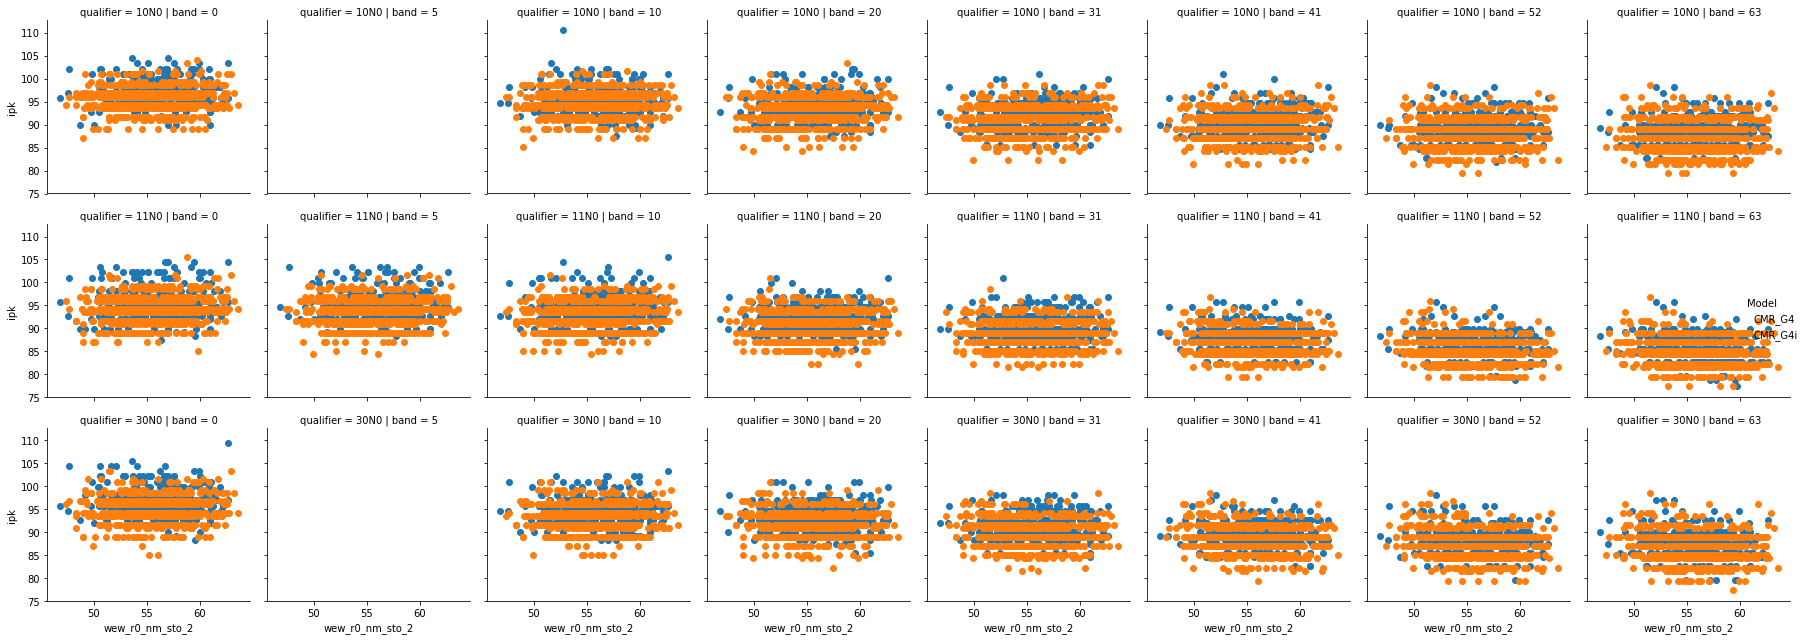

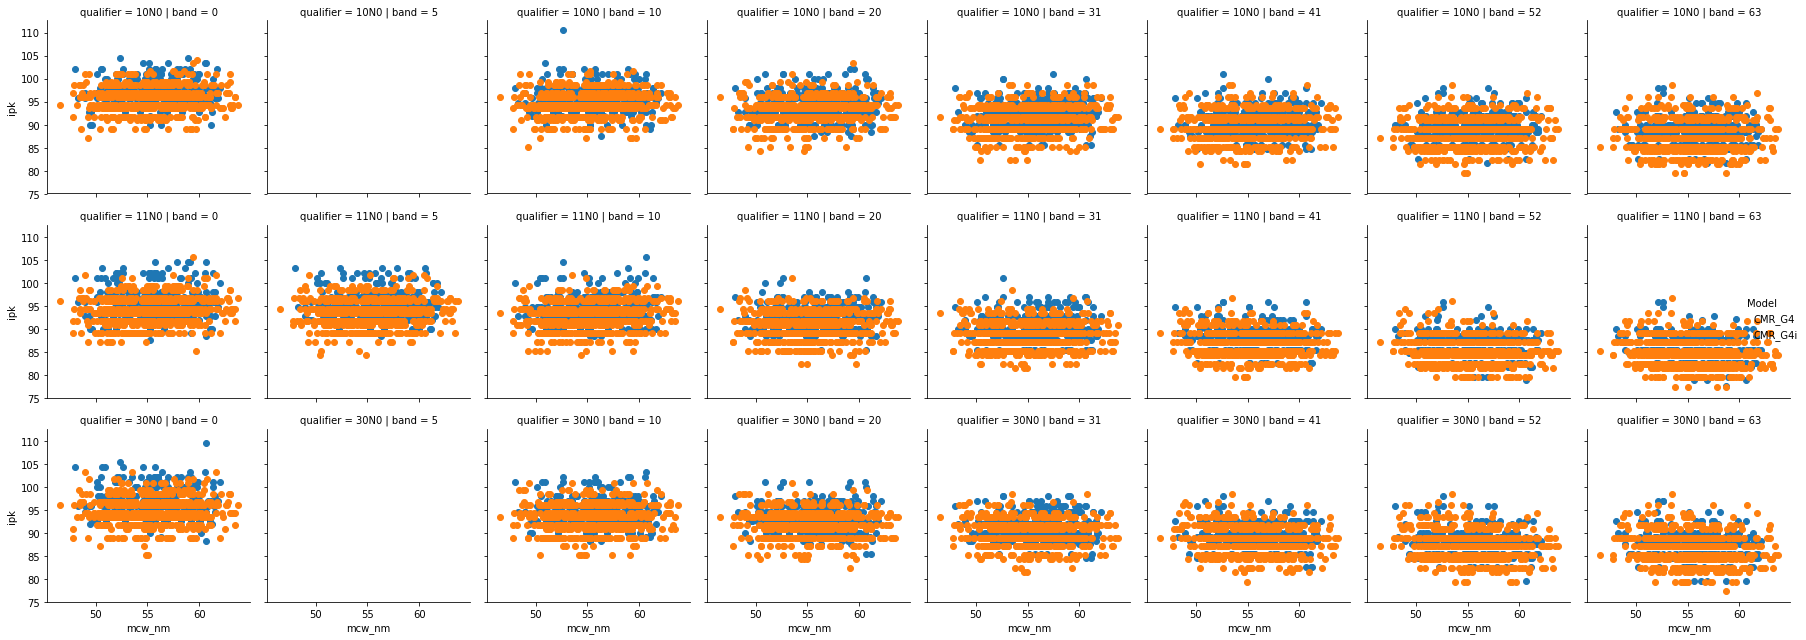

In [20]:
#MCW vs AIw

%matplotlib inline

#CMR
#df = make_group(pd.read_pickle('dfAIw.pkl').query("row_num==1"))
df0 = make_group(pd.read_pickle('hddops_association.pkl').query("row_num==1"))
df1 = make_group(pd.read_pickle('dfMcw.pkl').query("row_num==1"))
df = df1.query("band==1").merge(df0, 
               left_on =['hddsn', 'mfgid', 'hddtrial', 'phd',     'Model', 'row_num'], 
               right_on=['hddsn', 'mfgid', 'hddtrial', 'pheadno', 'Model', 'row_num'],
               how='left'
              )
df = df.merge(make_group(pd.read_pickle('dfAIw.pkl').query("row_num==1")),
              left_on =['hddsn', 'mfgid', 'hddtrial', 'phd', 'lhd', 'Model', 'row_num'],
              right_on=['hddsn', 'mfgid', 'hddtrial', 'phd', 'lhd', 'Model', 'row_num'],
              how='right',
              suffixes=['_mcw', '']
             )

#DET MCW vs PC
grid = sns.FacetGrid(df.query("wew_r0_nm_sto_2>0"), 
                     col='band',
                     row="qualifier",
                     row_order = ['10N0', '11N0', '30N0'],
                     hue='Model', 
                     legend_out=True,
                     hue_order=['CMR_G4', 'CMR_G4i'],
                     #palette="tab20c",
                     #palette="coolwarm",
                     #col_wrap=7, 
                     height=3)
grid.map(plt.scatter, 'wew_r0_nm_sto_2', 'ipk')
grid.add_legend()
#grid.set(#xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(xmin, xmax))
    # Draw a line plot to show the trajectory of each random walk
    #grid.map(plt.plot, "band", 'WriteCurrent')
    #grid.set(#xticks=np.arange(5), yticks=[-3, 3],
    #         ylim=(1e-1, 1000))
grid.fig.tight_layout(w_pad=1)
    #plt.show()
plt.savefig('detmcw_vs_aiw.png', format = 'png')
#plt.cla()
#plt.close() 


#MCW vs PC
grid = sns.FacetGrid(df.query("mcw_nm>0"), 
                     col='band',
                     row="qualifier",
                     row_order = ['10N0', '11N0', '30N0'],
                     hue='Model', 
                     legend_out=True,
                     hue_order=['CMR_G4', 'CMR_G4i'],
                     #palette="tab20c",
                     #palette="coolwarm",
                     #col_wrap=7, 
                     height=3)
grid.map(plt.scatter, 'mcw_nm', 'ipk')
grid.add_legend()
#grid.set(#xticks=np.arange(5), yticks=[-3, 3],
#         xlim=(xmin, xmax))
    # Draw a line plot to show the trajectory of each random walk
    #grid.map(plt.plot, "band", 'WriteCurrent')
    #grid.set(#xticks=np.arange(5), yticks=[-3, 3],
    #         ylim=(1e-1, 1000))
grid.fig.tight_layout(w_pad=1)
    #plt.show()
plt.savefig('mcw_vs_aiw.png', format = 'png')
#plt.cla()
#plt.close()

In [14]:
df0 = make_group(pd.read_pickle('hddops_association.pkl').query("row_num==1"))
df1 = make_group(pd.read_pickle('dfMcw.pkl').query("row_num==1"))
df = df1.query("band==1").merge(df0, 
               left_on =['hddsn', 'mfgid', 'hddtrial', 'phd',     'Model', 'row_num'], 
               right_on=['hddsn', 'mfgid', 'hddtrial', 'pheadno', 'Model', 'row_num'],
               how='left'
              )
df = df.merge(make_group(pd.read_pickle('dfAIw.pkl').query("row_num==1")),
              left_on =['hddsn', 'mfgid', 'hddtrial', 'phd', 'lhd', 'Model', 'row_num'],
              right_on=['hddsn', 'mfgid', 'hddtrial', 'phd', 'lhd', 'Model', 'row_num'],
              how='right',
              suffixes=['_mcw', '']
             )
df

,hddsn,pfcode_mcw,testcode_mcw,mfgid,hddtrial,qualifier_mcw,band_mcw,phd,lhd,mcw,...,ka,kd,bestser,readoffset,enddt,coef_a,coef_b,coef_c,coef_d,ipk
0,2FA052AA,0000,PDQC36VM,KKB304,M1HW,10N0,1,3,3,106.860352,...,37,4,-1.27,-0.64,20201005,-0.015471,1.684162,1.335028,0.387637,90.918011
1,2FA052AA,0000,PDQC36VM,KKB304,M1HW,10N0,1,3,3,106.860352,...,40,4,-2.01,-0.81,20201005,-0.015471,1.684162,1.335028,0.387637,94.271152
2,2FA052AA,0000,PDQC36VM,KKB304,M1HW,10N0,1,3,3,106.860352,...,39,4,-2.00,-0.34,20201005,-0.015471,1.684162,1.335028,0.387637,93.524018
3,2FA052AA,0000,PDQC36VM,KKB304,M1HW,10N0,1,3,3,106.860352,...,35,4,-1.87,-0.30,20201005,-0.015471,1.684162,1.335028,0.387637,87.107439
4,2FA052AA,0000,PDQC36VM,KKB304,M1HW,10N0,1,3,3,106.860352,...,36,4,-1.67,-0.44,20201005,-0.015471,1.684162,1.335028,0.387637,89.028196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21523,2FA0537A,0000,PDQC36VM,KKB304,M1HW,10N0,1,10,10,106.640625,...,38,4,-1.96,-0.56,20201005,-0.015471,1.684162,1.335028,0.387637,91.680616
21524,2FA0537A,0000,PDQC36VM,KKB304,M1HW,10N0,1,10,10,106.640625,...,39,4,-1.72,-0.60,20201005,-0.015471,1.684162,1.335028,0.387637,93.524018
21525,2FA0537A,0000,PDQC36VM,KKB304,M1HW,10N0,1,10,10,106.640625,...,36,4,-1.67,-0.39,20201005,-0.015471,1.684162,1.335028,0.387637,89.028196
21526,2FA0537A,0000,PDQC36VM,KKB304,M1HW,10N0,1,10,10,106.640625,...,40,4,-1.39,-0.70,20201005,-0.015471,1.684162,1.335028,0.387637,94.271152


# TSW

['PDQX073M', 'PDQC3EKM']
['PDQX073M', 'PDQC3EKM']


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\numpy\lib\function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:/dstools\prob_ellip.py:24: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(xdata, ydata)
C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\numpy\lib\function_base.py:2326: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\numpy\core\fromnum

['PDQX073M', 'PDQC3EKM']
['PDQX073M', 'PDQC3EKM']


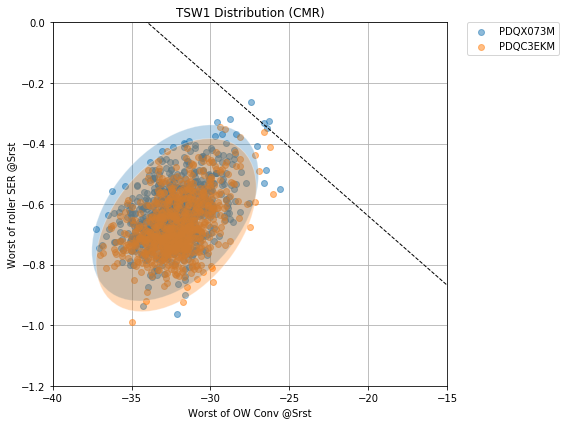

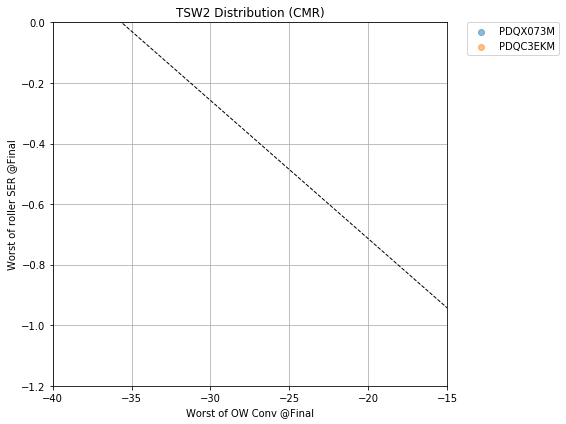

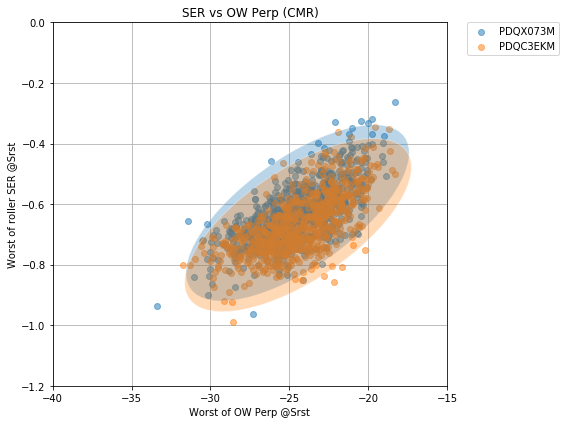

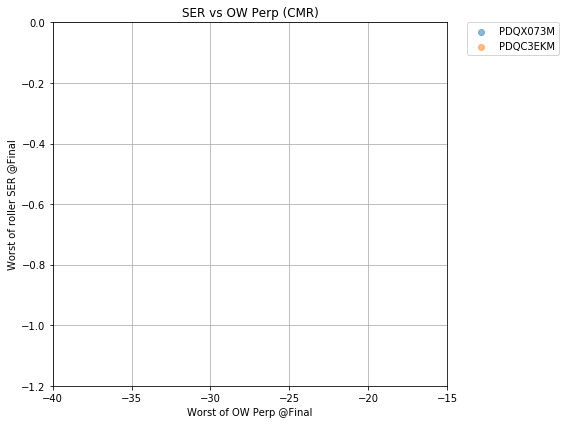

In [51]:
#TSW Plot
%matplotlib inline

df = make_group(pd.read_pickle('dfTsw.pkl').query("row_num==1"))
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

#dfFailHd = pd.read_csv('Fail_SNHD.csv')
#dfFailHd.loc[:,'tsw'] = '1_Fail'
#df = df.merge(dfFailHd, left_on=['hddsn', 'lhd'], right_on=['hddsn', 'lhd'], how='left')
#df.loc[df['tsw']!='1_Fail','tsw'] ='0_Pass'
#df.loc[(df['tsw']=='1_Fail') & (df['tsw_metric'] < df['thresh']),'tsw'] = '0_Pass'
#df.loc[(df['tsw']=='1_Fail') & (df['tsw_metric'] < df['thresh']),'tsw'] = '0_Pass'
#dfFailHdQa = pd.read_csv('Fail_SNHD_qa.csv')
#dfFailHdQa.loc[:,'qatest'] = 'Fail'
#df = df.merge(dfFailHdQa, left_on=['hddsn', 'lhd'], right_on=['hddsn', 'lhd'], how='left')
#df.loc[df['qatest']!='Fail','qatest'] ='Pass'
#df.loc[(df['tsw']=='1_Fail') & (df['qatest'] == 'Fail'),'tsw'] = '2_Fail_QA'
#df.loc[df['qatest'] == 'Fail','tsw'] = '2_Fail_QA'


coef = [0.0457, 0.0065];      #CMR and SMR
thresh = [-1.5537, -1.6286, -0.66903, -0.68404]; #CMR for SRST, CMR for Final, SMR for SRST, SMR for Final

#TSW1
plot_xy(df.query("firstQual=='9'"), 
        'owvalmaxconv', 'ser_for_tsw_metric', 
        'Worst of OW Conv @Srst', 'Worst of roller SER @Srst', 'TSW1 Distribution (CMR)', 
        'tsw1_owc_ser', disLegend=False, hue=hue, hue_order=hue_order,
        xlim=[-40,-15], ylim=[-1.2,0], 
        divX=None, divY=None, 
        addThresh=np.poly1d([-coef[0], thresh[0]]), addYXLine=None, addRegLine=False, addEllipse=True, sigma=3)

#TSW2
plot_xy(df.query("firstQual=='B'"), 
        'owvalmaxconv', 'ser_for_tsw_metric', 
        'Worst of OW Conv @Final', 'Worst of roller SER @Final', 'TSW2 Distribution (CMR)', 
        'tsw2_owc_ser', disLegend=False, hue=hue, hue_order=hue_order,
        xlim=[-40,-15], ylim=[-1.2,0], 
        divX=None, divY=None, 
        addThresh=np.poly1d([-coef[0], thresh[1]]), addYXLine=None, addRegLine=False, addEllipse=True, sigma=3)

#TSW1 (Over Write Perp)
plot_xy(df.query("firstQual=='9'"), 
        'owvalmaxperp', 'ser_for_tsw_metric', 
        'Worst of OW Perp @Srst', 'Worst of roller SER @Srst', 'SER vs OW Perp (CMR)', 
        'tsw1_owp_ser', disLegend=False, hue=hue, hue_order=hue_order,
        xlim=[-40,-15], ylim=[-1.2,0], 
        divX=None, divY=None, 
        addThresh=None, addYXLine=None, addRegLine=False, addEllipse=True, sigma=3)

#TSW2 (Over Write Perp)
plot_xy(df.query("firstQual=='B'"), 
        'owvalmaxperp', 'ser_for_tsw_metric', 
        'Worst of OW Perp @Final', 'Worst of roller SER @Final', 'SER vs OW Perp (CMR)', 
        'tsw2_owp_ser', disLegend=False, hue=hue, hue_order=hue_order,
        xlim=[-40,-15], ylim=[-1.2,0], 
        divX=None, divY=None, 
        addThresh=None, addYXLine=None, addRegLine=False, addEllipse=True, sigma=3)


#SMR
if rec_type != 'CMR':
#TSWH
    plot_xy(df.query("firstQual=='K'"), 
            'owvalmaxconv', 'ser_for_tsw_metric', 
            'Worst of OW Conv @Srst', 'Worst of roller SER @Srst', 'TSWH Distribution (SMR)', 
            'tswh_owc_ser', disLegend=False, hue=hue, hue_order=hue_order,
            xlim=[-40,-15], ylim=[-1.2,0], 
            divX=None, divY=None, 
            addThresh=np.poly1d([-coef[1], thresh[2]]), addYXLine=None, addRegLine=False, addEllipse=True, sigma=3)

#TSWJ
    plot_xy(df.query("firstQual=='M'"), 
            'owvalmaxconv', 'ser_for_tsw_metric', 
            'Worst of OW Conv @Final', 'Worst of roller SER @Final', 'TSWJ Distribution (SMR)', 
            'tswj_owc_ser', disLegend=False, hue=hue, hue_order=hue_order,
            xlim=[-40,-15], ylim=[-1.2,0], 
            divX=None, divY=None, 
            addThresh=np.poly1d([-coef[1], thresh[3]]), addYXLine=None, addRegLine=False, addEllipse=True, sigma=3)

#TSW (Over Write Perp)
    plot_xy(df.query("firstQual=='K'"), 
            'owvalmaxperp', 'ser_for_tsw_metric', 
            'Worst of OW Perp @Srst', 'Worst of roller SER @Srst', 'SER vs OW Perp (SMR)', 
            'tswh_owp_ser', disLegend=False, hue=hue, hue_order=hue_order,
            xlim=[-40,-15], ylim=[-1.2,0], 
            divX=None, divY=None, 
            addThresh=None, addYXLine=None, addRegLine=False, addEllipse=True, sigma=3)

#TSW (Over Write Perp)
    plot_xy(df.query("firstQual=='B'"), 
            'owvalmaxperp', 'ser_for_tsw_metric', 
            'Worst of OW Perp @Final', 'Worst of roller SER @Final', 'SER vs OW Perp (SMR)', 
            'tswj_owp_ser', disLegend=False, hue=hue, hue_order=hue_order,
            xlim=[-40,-15], ylim=[-1.2,0], 
            divX=None, divY=None, 
            addThresh=None, addYXLine=None, addRegLine=False, addEllipse=True, sigma=3)

['CMR_G4', 'CMR_G4i']
['CMR_G4', 'CMR_G4i']


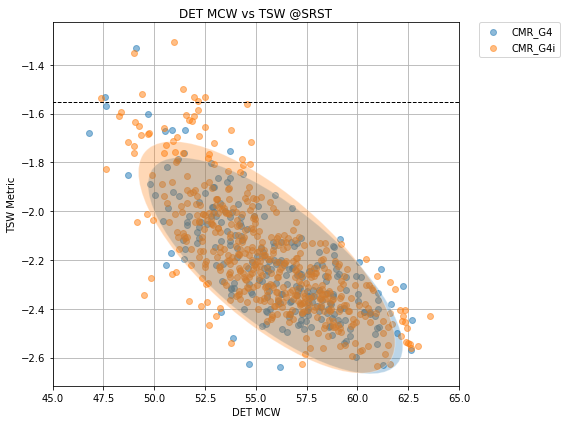

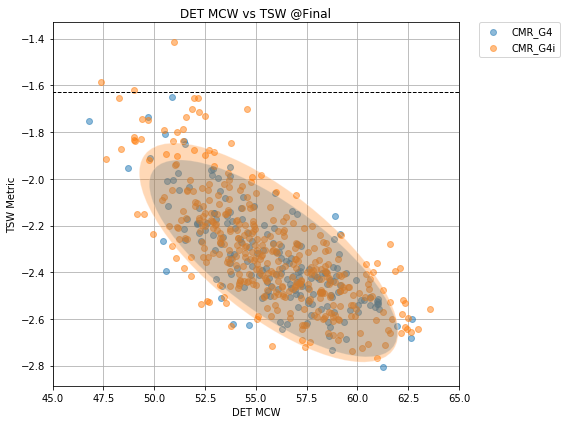

In [30]:
#MCW vs TSW Metric
df0 = make_group(pd.read_pickle('hddops_association.pkl').query("row_num==1"))
df1 = make_group(pd.read_pickle('dfMcw.pkl').query("row_num==1"))
df = df1.query("band==1").merge(df0, 
               left_on =['hddsn', 'mfgid', 'hddtrial', 'phd',     'Model', 'row_num'], 
               right_on=['hddsn', 'mfgid', 'hddtrial', 'pheadno', 'Model', 'row_num'],
               how='left'
              )
df = df.merge(make_group(pd.read_pickle('dfTsw.pkl').query("row_num==1")),
              left_on =['hddsn', 'mfgid', 'hddtrial', 'phd', 'lhd', 'Model', 'row_num'],
              right_on=['hddsn', 'mfgid', 'hddtrial', 'phd', 'lhd', 'Model', 'row_num'],
              how='right',
              suffixes=['_mcw', '']
             )

#TSW1
plot_xy(df.query("wew_r0_nm_sto_2 > 0 and firstQual=='9'"), 
        'wew_r0_nm_sto_2', 'tsw_metric', 
        'DET MCW', 'TSW Metric', 'DET MCW vs TSW @SRST', 
        'detmcw_vs_tsw1', disLegend=False, hue='Model', 
        xlim=[45,65], 
        #ylim=[-1.2,0], 
        divX=None, divY=None, 
        addThresh=np.poly1d([0, -1.5537]), addYXLine=None, addRegLine=False, addEllipse=True)

#TSW2
plot_xy(df.query("wew_r0_nm_sto_2 > 0 and firstQual=='B'"), 
        'wew_r0_nm_sto_2', 'tsw_metric', 
        'DET MCW', 'TSW Metric', 'DET MCW vs TSW @Final', 
        'detmcw_tsw2', disLegend=False, hue='Model', 
        xlim=[45,65],
        #ylim=[-1.2,0], 
        divX=None, divY=None, 
        addThresh=np.poly1d([0, -1.6286]), addYXLine=None, addRegLine=False, addEllipse=True)

# ATI

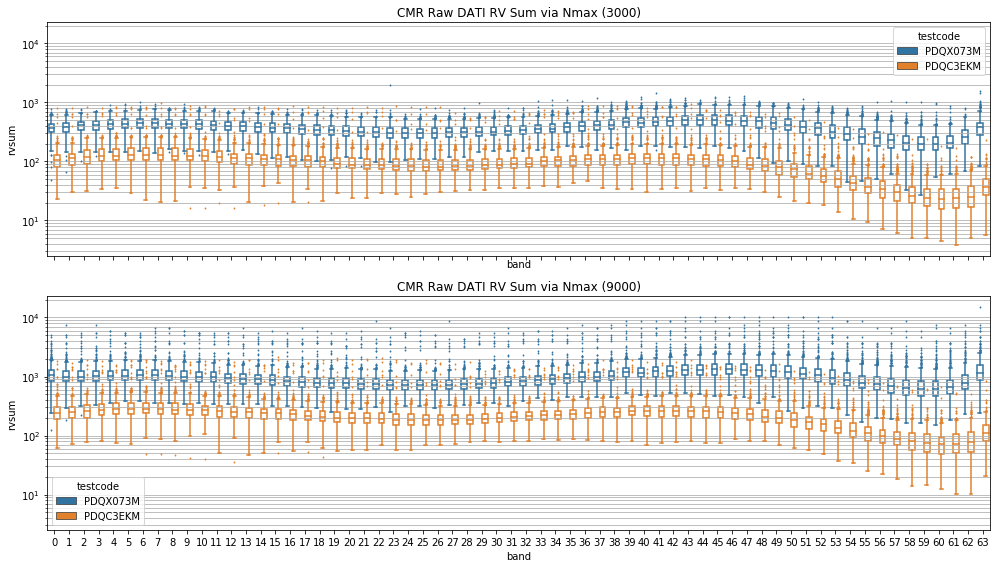

In [97]:
#Nmax of DATI
%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_ati_prim_bybandwrnum.pkl').query("row_num==1"))
df.loc[:,'rvsum'] = 2*30000/df.loc[:,'nmax50byband'].values
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]
df = df.astype({'nmax50byband':'float'})

#CMR
fig,ax=plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,8))
for h, qual in enumerate(['3000', '9000']):
    sns.boxplot(x='band', y='rvsum', hue=hue, 
                data=df.query("qualifier=='%s' and nmax50byband > 1 and nmax50byband < 1e6"%qual), 
                dodge=True, fliersize=1, ax=ax[h], 
                hue_order=hue_order, 
                #palette={'M1TY':'C0', 'M1Y1':'C1'}
                #color='C0'
               )
    for i,artist in enumerate(ax[h].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax[h].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
        
    ax[h].set_title('CMR Raw DATI RV Sum via Nmax (%s)'%qual)
    ax[h].set_yscale('log')
    #ax[h].set_ylim((1,1e6))
    ax[h].grid(axis='y', which='both')
plt.tight_layout()
plt.savefig('nmax_cmr.png', format='png')

C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


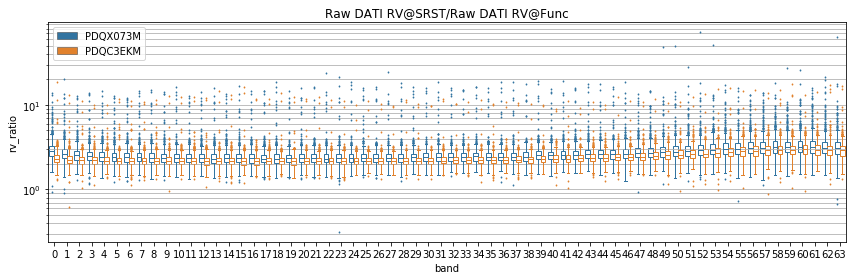

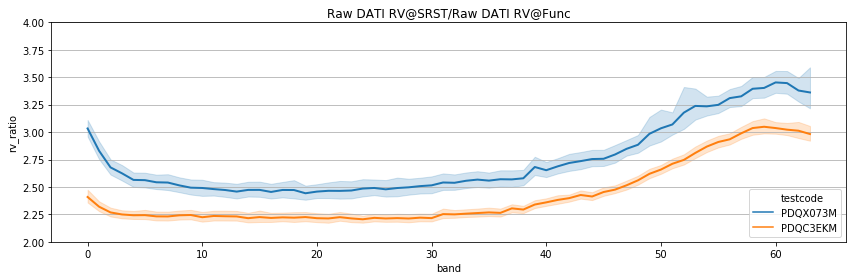

In [82]:
#Raw RV ratio via Nmax

%matplotlib inline

df = make_group(pd.read_pickle('dfNmaxTemp.pkl').query("row_num==1 and nmax50byband > 1"))
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'band'], keep=False)]

df.loc[:,'rv'] = 30000.0/df.loc[:,'nmax50byband'].values
dfflat = df.query("qualifier=='3000'").merge(df.query("qualifier=='9000'"),
                                                                left_on  = ['hddsn', 'testcode', 'mfgid', 'hddtrial', 'lhd', 'phd', 'band'],
                                                                right_on = ['hddsn', 'testcode', 'mfgid', 'hddtrial', 'lhd', 'phd', 'band'],
                                                                how='inner',
                                                                suffixes=['_func', '_srst'])
dfflat.loc[:,'rv_ratio'] = dfflat.loc[:,'rv_srst'].values/dfflat.loc[:,'rv_func'].values


#CMR
fig, ax = plt.subplots(1,1, sharey=True, figsize=(12,4))
sns.boxplot(x="band", y="rv_ratio", hue=hue, 
            data=dfflat, 
            ax=ax,
            hue_order=hue_order,
            #order=[x for x in range(64)],
            #order=[0,10,20,31,41,52,63],
            fliersize=1,
            linewidth=1)
for i,artist in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')
    
    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
ax.set_title('Raw DATI RV@SRST/Raw DATI RV@Func')
#ax[h].set_ylim((-0.5,1.0))
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.grid(axis='y', which='both')

plt.tight_layout()
plt.savefig('rv_ratio_cmr.png', format='png')

#average
fig, ax = plt.subplots(1,1, sharey=True, sharex=False, figsize=(12,4))
sns.lineplot(x="band", y="rv_ratio", hue=hue, 
             data=dfflat, 
             ax=ax,
             #ci=None,
             hue_order=hue_order,
             #legend='brief',
             #order=[x for x in range(64)],
             #order=[0,10,20,31,41,52,63],
             linewidth=2)
ax.set_title('Raw DATI RV@SRST/Raw DATI RV@Func')
ax.set_ylim((2, 4))
ax.grid(axis='y', which='both')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('rv_ratio_average_cmr.png', format='png')

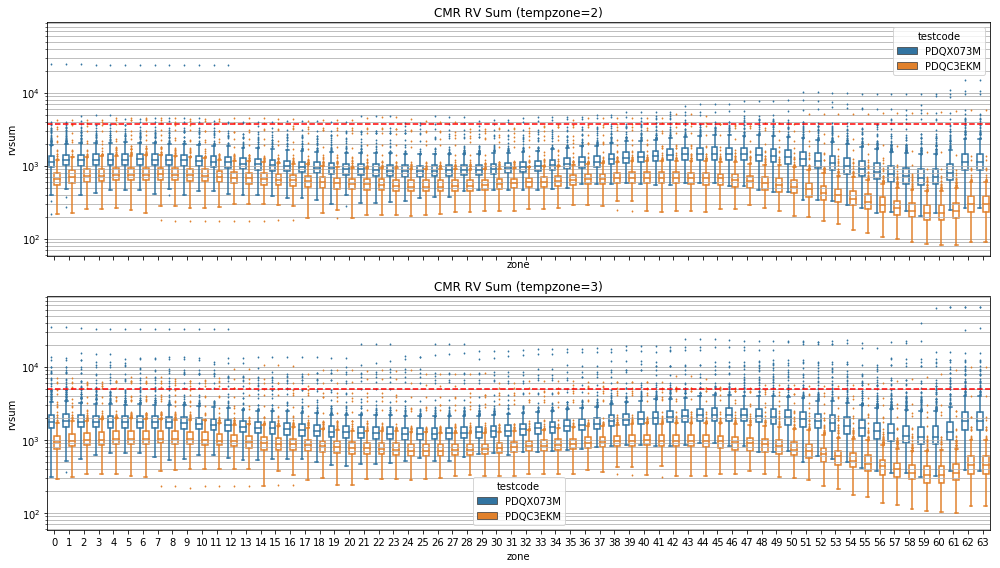

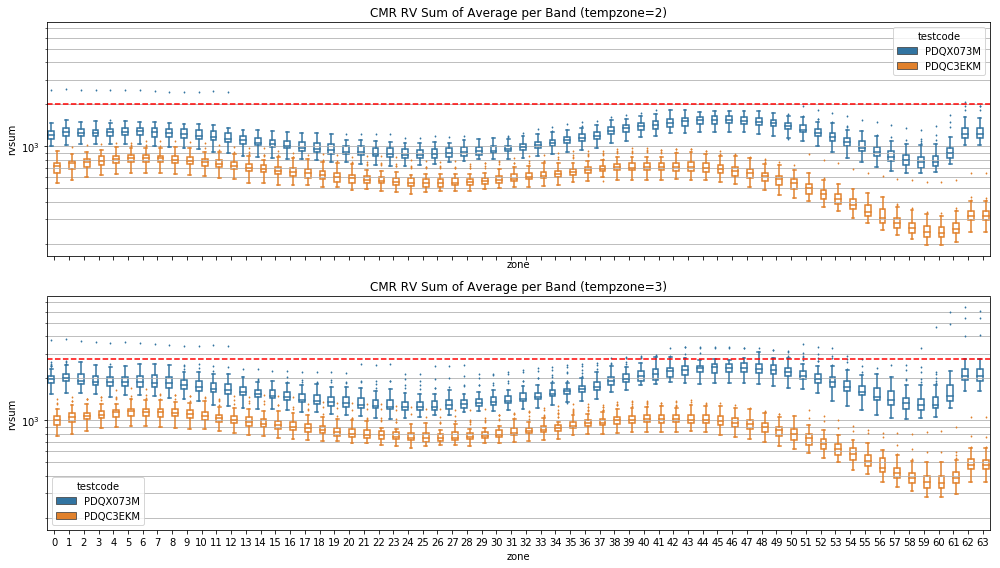

In [52]:
#64band RV
%matplotlib inline

trw_thr_dict = {1:30000/8.0, 2:30000/8.0, 3:30000/6.0}
trs_thr_dict = {1:30000/15, 2:30000/15, 3:30000/11}

df = make_group(pd.read_pickle('df_ccb_ci_dati_theta.pkl').query("row_num==1"))
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'zone', 'tempzone'], keep=False)]

#CMR
fig,ax=plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,8))
for h, tempzone in enumerate([2, 3]):
    sns.boxplot(x='zone', y='rvsum', hue=hue, 
                data=df.query("qualifier.str.startswith('900') and rvsum >= 1 and tempzone==%d"%tempzone),  
                dodge=True, fliersize=1, ax=ax[h], 
                hue_order=hue_order, 
                #palette={'M1TY':'C0', 'M1Y1':'C1'}
                #color='C0'
               )
    for i,artist in enumerate(ax[h].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax[h].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
        
    ax[h].set_title('CMR RV Sum (tempzone=%d)'%tempzone)
    ax[h].set_yscale('log')
    ax[h].axhline(trw_thr_dict[tempzone], c='red', linestyle='dashed')
    #ax[h].set_ylim((1,1e6))
    ax[h].grid(axis='y', which='both')
plt.tight_layout()
plt.savefig('rvsum_cmr.png', format='png')


#CMR, average by zone
fig,ax=plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,8))
dfpivot=pd.pivot_table(df, 
                       index=['hddsn', 'zone', 'qualifier', 'tempzone', 'testcode'], values=['rvsum'], 
                       aggfunc=np.mean).reset_index(drop=False)
for h, tempzone in enumerate([2, 3]):
    sns.boxplot(x='zone', y='rvsum', hue=hue, 
                data=dfpivot.query("qualifier.str.startswith('900') and rvsum >= 1 and tempzone==%d"%(tempzone)), 
                dodge=True, fliersize=1, ax=ax[h], 
                hue_order=hue_order, 
                #palette={'M1TY':'C0', 'M1Y1':'C1'}
                #color='C0'
               )
    for i,artist in enumerate(ax[h].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax[h].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
        
    ax[h].set_title('CMR RV Sum of Average per Band (tempzone=%d)'%tempzone)
    ax[h].set_yscale('log')
    ax[h].axhline(trs_thr_dict[tempzone], c='red', linestyle='dashed')
    #ax[h].set_ylim((1,1e6))
    ax[h].grid(axis='y', which='both')
plt.tight_layout()
plt.savefig('rvsum_average_cmr.png', format='png')


['PDQX073M', 'PDQC3EKM']


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


['PDQX073M', 'PDQC3EKM']
['PDQX073M', 'PDQC3EKM']
['PDQX073M', 'PDQC3EKM']


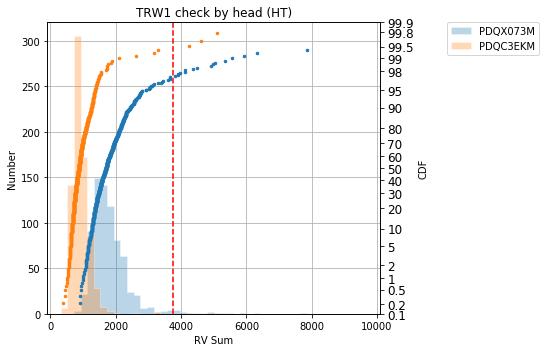

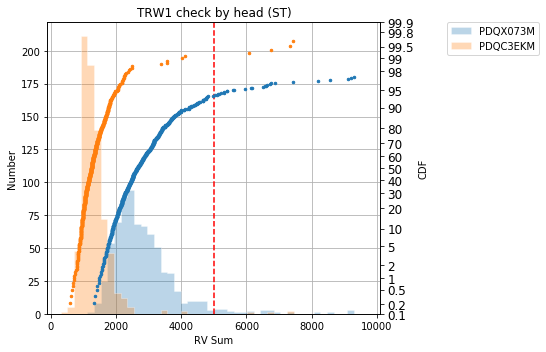

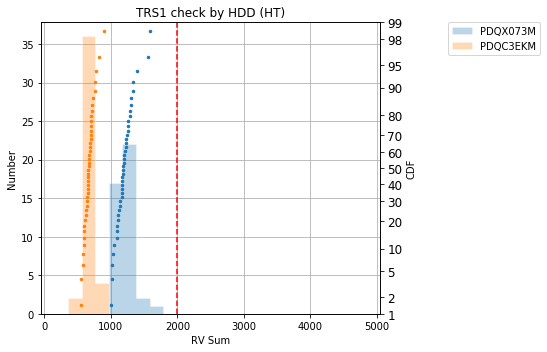

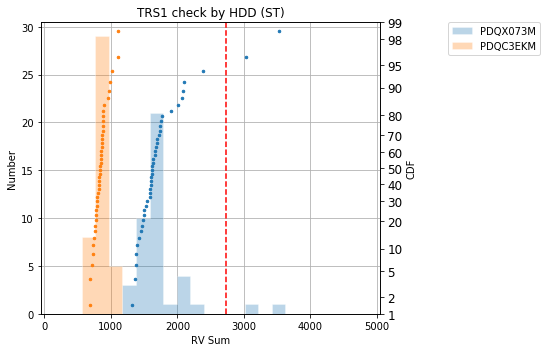

In [66]:
#TRW1 and TRS1 check
%matplotlib inline

trw_thr_dict = {1:30000/8.0, 2:30000/8.0, 3:30000/6.0}
trs_thr_dict = {1:30000/15, 2:30000/15, 3:30000/11}

df = make_group(pd.read_pickle('df_ccb_ci_dati_theta.pkl').query("row_num==1"))
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'zone', 'tempzone'], keep=False)]

df_wst_pivot = pd.pivot_table(df, index=['hddsn', 'testcode', 'tempzone', 'lhd'], values=['rvsum'], aggfunc=np.max).reset_index(drop=False)
df_avg_pivot = pd.pivot_table(pd.pivot_table(df, index=['hddsn', 'testcode', 'tempzone', 'zone'], values=['rvsum'], aggfunc=np.mean).reset_index(drop=False), 
                              index=['hddsn', 'testcode', 'tempzone'], values=['rvsum'], aggfunc=np.max).reset_index(drop=False)

    
#TRW1 check
plot_cdf2(df_wst_pivot.query("tempzone==2"),  
          'rvsum', 
          'RV Sum', 'TRW1 check by head (HT)', 
          'trw1_ht_qqplot', 
           binSize=50, div=None, addTable=False, addThresh=trw_thr_dict[2], 
           hue=hue, hue_order=hue_order, doBoxCox=False, xlim=[0,10000])
plot_cdf2(df_wst_pivot.query("tempzone==3"),  
          'rvsum', 
          'RV Sum', 'TRW1 check by head (ST)', 
          'trw1_st_qqplot', 
           binSize=50, div=None, addTable=False, addThresh=trw_thr_dict[3], 
           hue=hue, hue_order=hue_order, doBoxCox=False, xlim=[0,10000])

#TRS1 check
plot_cdf2(df_avg_pivot.query("tempzone==2"),  
          'rvsum', 
          'RV Sum', 'TRS1 check by HDD (HT)', 
          'trs1_ht_qqplot', 
           binSize=25, div=None, addTable=False, addThresh=trs_thr_dict[2], 
           hue=hue, hue_order=hue_order, doBoxCox=False, xlim=[0,5000])
plot_cdf2(df_avg_pivot.query("tempzone==3"),  
          'rvsum', 
          'RV Sum', 'TRS1 check by HDD (ST)', 
          'trs1_st_qqplot', 
           binSize=25, div=None, addTable=False, addThresh=trs_thr_dict[3], 
           hue=hue, hue_order=hue_order, doBoxCox=False, xlim=[0,5000])

['PDQX073M', 'PDQC3EKM']


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


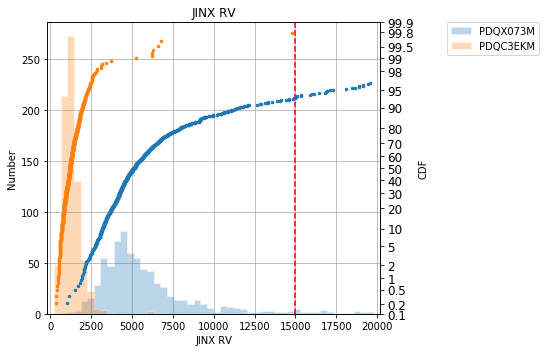

In [53]:
# JINX RV
%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_ati_mcsb_ns.pkl').query("row_num==1"))
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd'], keep=False)]

plot_cdf2(df,  
          'maxrvcheck4nonlinearxcor_0', 
          'JINX RV', 'JINX RV', 
          'jinxrv_qqplot', 
           binSize=50, div=None, addTable=False, addThresh=15000, 
           hue=hue, hue_order=hue_order, doBoxCox=False, xlim=[0,20000])

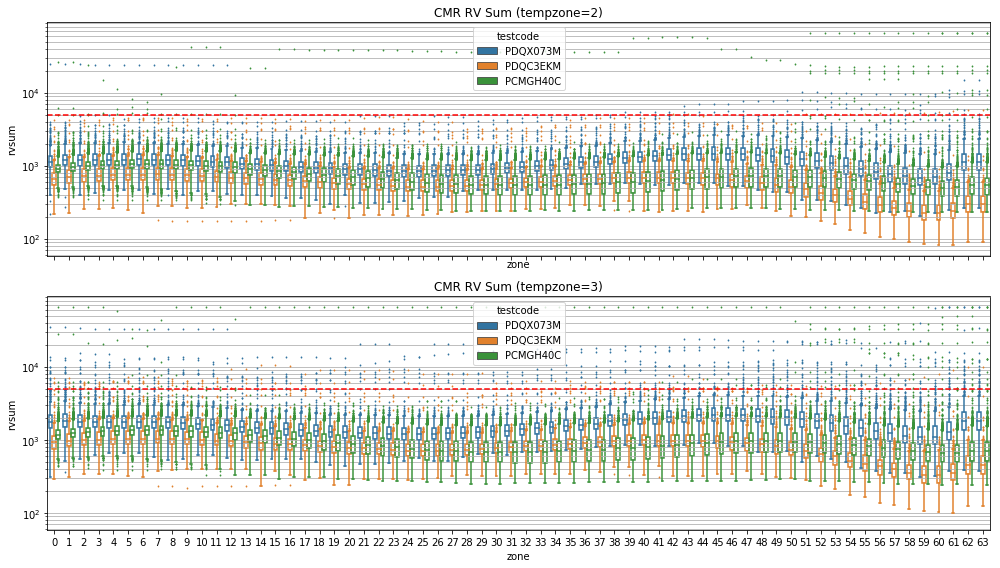

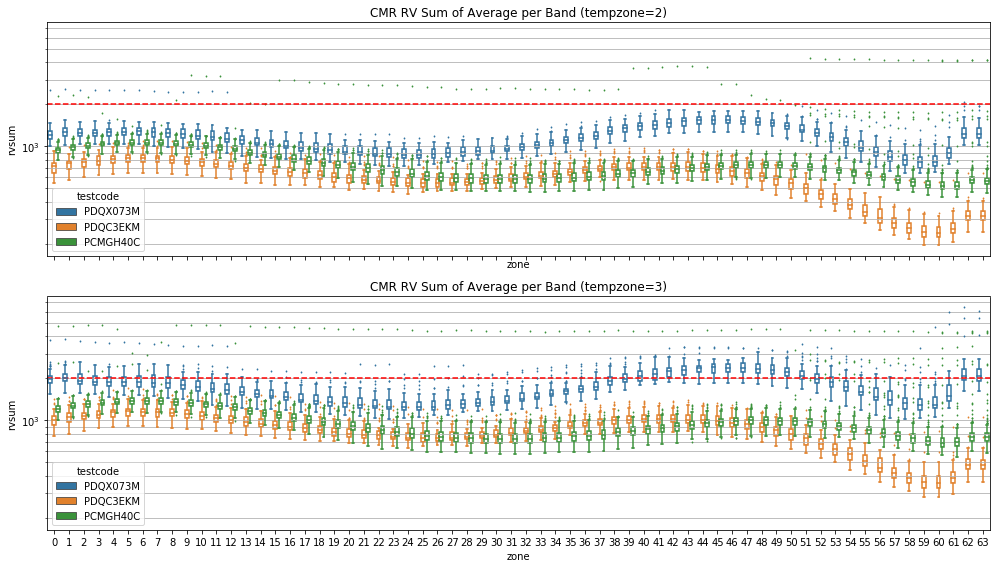

In [26]:
#64band RV: PCM vs PDQ

%matplotlib inline

df = make_group(pd.read_pickle('df_ccb_ci_dati_theta.pkl').query("row_num==1"))
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'zone', 'tempzone'], keep=False)]

#append PCM data
df = df.append(pd.read_pickle('pcm/df_ccb_ci_dati_theta.pkl').query("row_num==1"))

hue = 'testcode'
hue_order = ['PDQX073M', 'PDQC3EKM', 'PCMGH40C']

#CMR
fig,ax=plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,8))
for h, tempzone in enumerate([2, 3]):
    sns.boxplot(x='zone', y='rvsum', hue=hue,
                data=df.query("qualifier.str.startswith('900') and rvsum >= 1 and tempzone==%d"%tempzone), 
                dodge=True, fliersize=1, ax=ax[h], 
                hue_order=hue_order, 
                #palette={'M1TY':'C0', 'M1Y1':'C1'}
                #color='C0'
               )
    for i,artist in enumerate(ax[h].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax[h].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
        
    ax[h].set_title('CMR RV Sum (tempzone=%d)'%tempzone)
    ax[h].set_yscale('log')
    ax[h].axhline(5000, c='red', linestyle='dashed')
    #ax[h].set_ylim((1,1e6))
    ax[h].grid(axis='y', which='both')
plt.tight_layout()
plt.savefig('rvsum_pdq_vs_pcm_cmr.png', format='png')


#CMR, average by zone
fig,ax=plt.subplots(2,1, sharex=True, sharey=True, figsize=(14,8))
dfpivot=pd.pivot_table(df, 
                       index=['hddsn', 'zone', 'qualifier', 'tempzone', 'testcode'], values=['rvsum'], 
                       aggfunc=np.mean).reset_index(drop=False)
for h, tempzone in enumerate([2, 3]):
    sns.boxplot(x='zone', y='rvsum', hue=hue, 
                data=dfpivot.query("qualifier.str.startswith('900') and rvsum >= 1 and tempzone==%d"%(tempzone)), 
                dodge=True, fliersize=1, ax=ax[h], 
                hue_order=hue_order, 
                #palette={'M1TY':'C0', 'M1Y1':'C1'}
                #color='C0'
               )
    for i,artist in enumerate(ax[h].artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*6,i*6+6):
            line = ax[h].lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
        
    ax[h].set_title('CMR RV Sum of Average per Band (tempzone=%d)'%tempzone)
    ax[h].set_yscale('log')
    ax[h].axhline(2000, c='red', linestyle='dashed')
    #ax[h].set_ylim((1,1e6))
    ax[h].grid(axis='y', which='both')
plt.tight_layout()
plt.savefig('rvsum_average_pdq_vs_pcm_cmr.png', format='png')

['PDQX073M', 'PDQC3EKM', 'PCMGH40C']


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


['PDQX073M', 'PDQC3EKM', 'PCMGH40C']
['PDQX073M', 'PDQC3EKM', 'PCMGH40C']
['PDQX073M', 'PDQC3EKM', 'PCMGH40C']


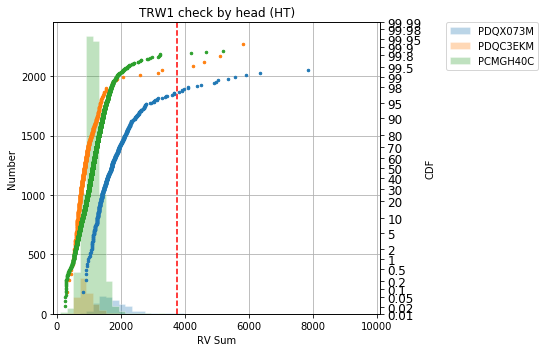

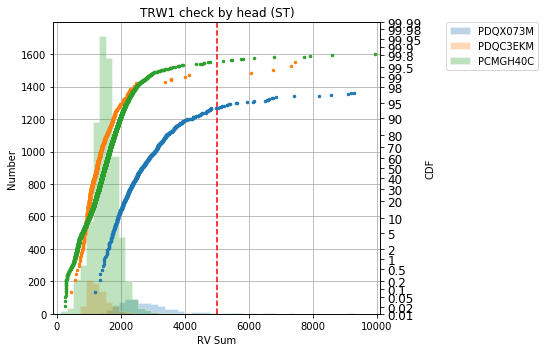

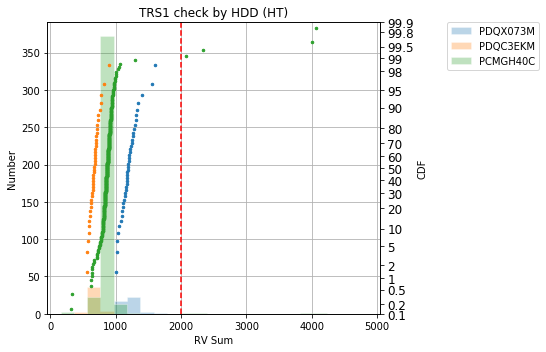

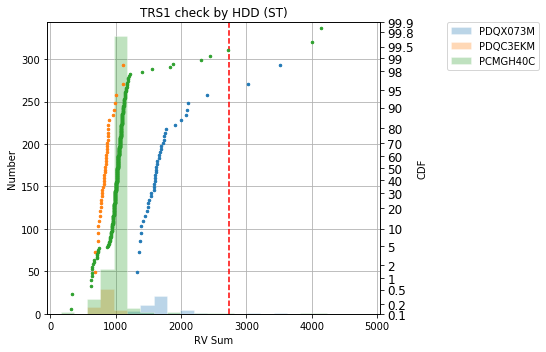

In [67]:
#TRW1 and TRS1 check, PCM vs PDQ
%matplotlib inline

hue_order2 = ['PDQX073M', 'PDQC3EKM', 'PCMGH40C']

trw_thr_dict = {1:30000/8.0, 2:30000/8.0, 3:30000/6.0}
trs_thr_dict = {1:30000/15, 2:30000/15, 3:30000/11}

df = make_group(pd.read_pickle('df_ccb_ci_dati_theta.pkl').query("row_num==1"))
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd', 'zone', 'tempzone'], keep=False)]
#append PCM data
df = df.append(pd.read_pickle('pcm/df_ccb_ci_dati_theta.pkl').query("row_num==1"))


df_wst_pivot = pd.pivot_table(df, index=['hddsn', 'testcode', 'tempzone', 'lhd'], values=['rvsum'], aggfunc=np.max).reset_index(drop=False)
df_avg_pivot = pd.pivot_table(pd.pivot_table(df, index=['hddsn', 'testcode', 'tempzone', 'zone'], values=['rvsum'], aggfunc=np.mean).reset_index(drop=False), 
                              index=['hddsn', 'testcode', 'tempzone'], values=['rvsum'], aggfunc=np.max).reset_index(drop=False)

#TRW1 check
plot_cdf2(df_wst_pivot.query("tempzone==2"),  
          'rvsum', 
          'RV Sum', 'TRW1 check by head (HT)', 
          'trw1_ht_pcm_vs_pdq_qqplot', 
           binSize=50, div=None, addTable=False, addThresh=trw_thr_dict[2], 
           hue=hue, hue_order=hue_order2, doBoxCox=False, xlim=[0,10000])
plot_cdf2(df_wst_pivot.query("tempzone==3"),  
          'rvsum', 
          'RV Sum', 'TRW1 check by head (ST)', 
          'trw1_st_pcm_vs_pdq_qqplot', 
           binSize=50, div=None, addTable=False, addThresh=trw_thr_dict[3], 
           hue=hue, hue_order=hue_order2, doBoxCox=False, xlim=[0,10000])

#TRS1 check
plot_cdf2(df_avg_pivot.query("tempzone==2"),  
          'rvsum', 
          'RV Sum', 'TRS1 check by HDD (HT)', 
          'trs1_ht_pcm_vs_pdq_qqplot', 
           binSize=25, div=None, addTable=False, addThresh=trs_thr_dict[2], 
           hue=hue, hue_order=hue_order2, doBoxCox=False, xlim=[0,5000])
plot_cdf2(df_avg_pivot.query("tempzone==3"),  
          'rvsum', 
          'RV Sum', 'TRS1 check by HDD (ST)', 
          'trs1_st_pcm_vs_pdq_qqplot', 
           binSize=25, div=None, addTable=False, addThresh=trs_thr_dict[3], 
           hue=hue, hue_order=hue_order2, doBoxCox=False, xlim=[0,5000])

['PDQX073M', 'PDQC3EKM', 'PCMGH40C']


C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\Users\339340273\AppData\Local\Continuum\anaconda3\envs\gaku\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


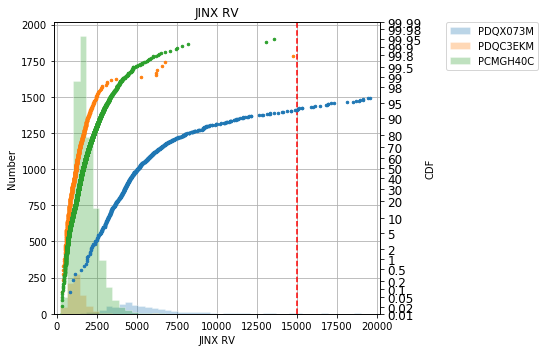

In [27]:
# JINX RV: PCM vs PDQ 
%matplotlib inline

hue_order = ['PDQX073M', 'PDQC3EKM', 'PCMGH40C']
df = make_group(pd.read_pickle('df_ccb_ci_ati_mcsb_ns.pkl').query("row_num==1"))
#duplication check
if a2a==True:
    df = df[df.duplicated(subset=['hddsn', 'qualifier', 'lhd'], keep=False)]

#append PCM data
df = df.append(pd.read_pickle('pcm/df_ccb_ci_ati_mcsb_ns.pkl').query("row_num==1"))
#df.loc[:,'testcode'] = 'PCM'
    
plot_cdf2(df,  
          'maxrvcheck4nonlinearxcor_0', 
          'JINX RV', 'JINX RV', 
          'jinxrv_pcm_vs_pdq_qqplot', 
           binSize=50, div=None, addTable=False, addThresh=15000, 
           hue='testcode', hue_order=hue_order, doBoxCox=False, xlim=[0,20000])

# Power Point Package

In [83]:
from pptx import Presentation
from pptx.util import Inches
from pptx.util import Pt
from pptx.util import Cm

prs = Presentation('template.pptx')

"""
#summery page template
nameObjects = ['Group', 'HDD Count', 'Build', 'Test Code', 'Mfgid', 'HDD Trial', 'Wafer', 'Media', 'Notes']
#hueName   = 'mfgid'
index4Num = 1
index4hue = 0
nCols = len(nameObjects)
hueList = list(np.sort(dfForPlot.loc[:,hueName].unique()))
nRows = len(hueList) 
dfCount = dfForPlot.query("lhd==0").loc[:,hueName].value_counts()

blank_slide_layout = prs.slide_layouts[3]
slide = prs.slides.add_slide(blank_slide_layout)
slide.shapes.title.text = 'Summery'
left = top = Inches(1)
width  = Cm(24) # Inches(6.0)
height = Cm(6) # Inches(0.8)
table = slide.shapes.add_table(nRows+1, nCols, left, top, width, height).table

# set column widths
for i in range(nCols):
    table.columns[i].width = Cm(3)
    table.cell(0, i).text = nameObjects[i]
    
# hdd count
for i in range(nRows):
    hueVal = hueList[i]
    table.cell(i+1, index4Num).text = str(dfCount.loc[hueVal])
    table.cell(i+1, index4hue).text = hueVal
"""

titles_figs = [
               ['Amp', 'amp.png'],
               ['Asymmetry', 'asm.png'],
               ['SNR', 'snr.png'],
               ['Over Write', 'ow.png'],
               ['SER', 'ser.png'],
               ['PDR', 'pdr.png'],
               ['RSBN', 2, 'rsbn_cmr.png', 'rsbn_smr.png']
              ]
    
# title and picture
for tp in titles_figs:
    title = tp[0]
    blank_slide_layout = prs.slide_layouts[3]
    slide = prs.slides.add_slide(blank_slide_layout)
    slide.shapes.title.text = title
    #slide.shapes.title.text_frame.paragraphs[0].font.size=Pt(10)
    
    #left = top = Inches(1)
    l, t = Cm(1), Cm(2)
    if type(tp[1]) == str:
        img_path = tp[1]
        pic = slide.shapes.add_picture(img_path, left=l, top=t)
    elif tp[1] == 2:
        h=Cm(11.5)
        pic = slide.shapes.add_picture(tp[2], left=Cm(1),    top=t, height=h)
        pic = slide.shapes.add_picture(tp[3], left=Cm(16.33), top=t, height=h)
    elif tp[1] == 3:
        h=Cm(8.0)
        pic = slide.shapes.add_picture(tp[2], left=Cm(1),     top=t, height=h)
        pic = slide.shapes.add_picture(tp[3], left=Cm(11.67), top=t, height=h)
        pic = slide.shapes.add_picture(tp[4], left=Cm(22.33), top=t, height=h)
    elif tp[1] == 4:
        h=Cm(8.0)
        pic = slide.shapes.add_picture(tp[2], left=Cm(1),     top=t, height=h)
        pic = slide.shapes.add_picture(tp[3], left=Cm(11.67), top=t, height=h)
        pic = slide.shapes.add_picture(tp[4], left=Cm(1),     top=t+h, height=h)
        pic = slide.shapes.add_picture(tp[5], left=Cm(11.67), top=t+h, height=h)
    elif tp[1] == 6:
        h=Cm(8.0)
        pic = slide.shapes.add_picture(tp[2], left=Cm(1),     top=t, height=h)
        pic = slide.shapes.add_picture(tp[3], left=Cm(11.67), top=t, height=h)
        pic = slide.shapes.add_picture(tp[4], left=Cm(22.33), top=t, height=h)
        pic = slide.shapes.add_picture(tp[5], left=Cm(1),     top=t+h, height=h)
        pic = slide.shapes.add_picture(tp[6], left=Cm(11.67), top=t+h, height=h)
        pic = slide.shapes.add_picture(tp[7], left=Cm(22.33), top=t+h, height=h)

#left = Inches(5)
#height = Inches(5.5)
#pic = slide.shapes.add_picture(img_path, left, top, height=height)

prs.save('pref1_test.pptx')